In [1]:
from init_analysis import *



In [13]:
meta_file_dir = my.check_if_dir_exists(str(result_dir / 'individual_graphs'))
meta_file_name = 'graphs_meta'

In [15]:
#generate subject graphs
remove_self_loops = True
map_type = 'act_map'
# Set step parameters
thresh = 1

avg_graphs = dict()
graph_list = dict()
meta = dict()
step_name = map_type + '_event_graph'
meta[step_name] = dict()

label = list()
mouse = list()
uqid = list()
index = list()

df = pd.DataFrame()

# Loop over subjects
for i, subject_file in enumerate(subject_jsons):
    #try:
    with open(subject_file, 'r') as f:
        subject_json = json.load(f)
    
     # Set step parameters
    thresh = 1
    av_json['parameters']['threshold'] = thresh
    av_json['needs'] = f'event_network_thresh_{thresh}'
    av_json['type'] = 'avalanches'
    
    # Load nodes
    try :
        dmeta = subject_json[av_json['needs']]['act_map_nodes']
        nodes = my.get_needed_derivative(dmeta, subject_json, project)
    except:
        print('nodes does not exist, i = ' + str(i))
        continue
        
    
    # Load edges
    try:
        dmeta = subject_json[av_json['needs']]['act_map_edges']
        edges = my.get_needed_derivative(dmeta, subject_json, project)
    except:
        print('edges does not exist, i = ' + str(i))
        continue

    
    # Extract label
    condition = subject_json['init']['condition']
    if 'cohort' in condition:
        condition = re.sub(r'_cohort\d+', '', condition)

    G = my.make_graph(nodes, edges, condition)
    
    #add the selfloops as a node attribute
    selfloops = list(nx.selfloop_edges(G))
    slweights = {sl[0]: G[sl[0]][sl[1]]['weight'] for sl in selfloops }
    nx.set_node_attributes(G, slweights, 'selfloops')
    
    if remove_self_loops:
        G.remove_edges_from(nx.selfloop_edges(G))

    mapping = dict()
    for node in G.nodes():
        mapping[node] = node.replace('left', 'L').replace('right', 'R') 
    G = nx.relabel_nodes(G, mapping)
    
    graph_list[i] = G

    
    label.append(condition)
    mouse.append(subject_json['init']['mouse'])
    uqid.append(subject_json['init']['uniqueid'])
    index.append(i)

    #save the averaged graphs
    save_dir = subject_json['init']['project_root'] + subject_json['init']['derivative_path']#my.check_if_dir_exists(str(result_dir) + '/' + 'individual_graphs/graphs/' + 'recid=' + str(i) + '_id=' + str(subject_json['init']['uniqueid']))
    subject_json[step_name] = dict()
    subject_json[step_name]['thresh=' + str(thresh)] = {'path': str(save_dir) + '/' + step_name,
                                        'save_dir': str(save_dir),
                                        'save_name': step_name + '_thresh=' + str(thresh),
                                        'format' : 'gml',
                                        'num_nodes' : len(G.nodes()),
                                        'num_edges' : len(G.edges()),
                                        'directed' : nx.is_directed(G),
                                        'weighted' : nx.is_weighted(G),
                                        'connected' : nx.is_strongly_connected(G),
                                        'map_type' : map_type
                                       }
    meta[step_name][i] = subject_json[step_name]['thresh=' + str(thresh)] 
    #save the graph as gephi file
    nx.write_gml(G, save_dir + '/' + subject_json[step_name]['thresh=' + str(thresh)]['save_name'] + '.gml')
    with open(subject_file, 'w') as f:
        json.dump(subject_json, f)
    

#df = pd.DataFrame({'keys' : index, 'cond': label, 'mouse': mouse, 'uniqueid': uqid})
with open(meta_file_dir + '/' + meta_file_name + '.pkl', 'wb') as f:
    pickle.dump(meta, f)  



NameError: name 'stop' is not defined

In [25]:
test = {'a':'b'}
'c' in test.keys()
    

False

In [3]:
#gen LR averaged graphs

map_type = 'act_map'
step_name = map_type + '_event_graph'
thresh = 1
need_step = step_name
graphs_list = dict()

# Loop over subjects
for i, subject_file in enumerate(subject_jsons):
    #try:
    with open(subject_file, 'r') as f:
        subject_json = json.load(f)

    path_name = subject_json['init']['project_root'] + subject_json['init']['derivative_path']
    file_name = subject_json[need_step]['thresh=' + str(thresh)]['save_name']
    G_OG = nx.read_gml(path_name + '/' + file_name + '.gml')
    
    LRnodes = {'L':list(), 'R': list()}
    for node in G_OG.nodes():
        LRnodes[node[-1]].append(node)

    GL = G_OG.subgraph(LRnodes['L'])
    GR = G_OG.subgraph(LRnodes['R'])

    GL = nx.relabel_nodes(GL, {node: node[0:-1].strip() for node in GL.nodes()})
    GR = nx.relabel_nodes(GR, {node: node[0:-1].strip() for node in GR.nodes()})

    G = my.average_hemisphere_graphs(GL, GR)

    step_name = map_type + '_LRavgd_graph' + '_thresh=' + str(thresh)
    save_dir = subject_json['init']['project_root'] + subject_json['init']['derivative_path']

    subject_json[need_step]['thresh=' + str(thresh)]['left_right_avgd'] = step_name
    nx.write_gml(G, save_dir + '/' + subject_json[need_step]['thresh=' + str(thresh)]['left_right_avgd'] + '.gml')
    
    with open(subject_file, 'w') as f:
        json.dump(subject_json, f)

    

In [11]:
save_dir

'/scratch4/calcium_data/projects/acute_stress//derivatives//Alex Acute Stress Cohort 3/Acute Stress/Post Shock/422M_Spontaneous_50Hz_noiso/'

In [35]:
#calculate graph stats

map_type = 'act_map'
need_step = map_type + '_event_graph'
thresh = 1
graphs_list = dict()

# Loop over subjects
for i, subject_file in enumerate(subject_jsons):
    #try:
    with open(subject_file, 'r') as f:
        subject_json = json.load(f)

    path_name = subject_json['init']['project_root'] + subject_json['init']['derivative_path']
    file_name = subject_json[need_step]['thresh=' + str(thresh)]['left_right_avgd']
    G = nx.read_gml(path_name + '/' + file_name + '.gml')

    stats_df,G = my.calculate_node_proprties(G, i)
    save_dir = subject_json['init']['project_root'] + subject_json['init']['derivative_path']
    nx.write_gml(G, save_dir + '/' + subject_json[need_step]['thresh=' + str(thresh)]['left_right_avgd'] + '.gml')

    

In [139]:
def build_node_dataframe(subject_nodedata, condition_lookup):
    all_data = []

    for subject_id, nodedata in subject_nodedata.items():
        condition = condition_lookup.get(subject_id, "unknown")
        for brain_region, props in nodedata.items():
            row = props.copy()
            row['Brain Region'] = brain_region
            row['subject'] = subject_id
            row['condition'] = condition
            all_data.append(row)

    return pd.DataFrame(all_data)


#collect node stats into dataframe
map_type = 'act_map'
need_step = map_type + '_event_graph'
graphs_list = dict()

subject_nodedata = dict()
condition_lookup = dict()
# subject_nodedata = {
#     "sub-01": nodedata1,
#     "sub-02": nodedata2,
#     # ...
# }

# Loop over subjects
for i, subject_file in enumerate(subject_jsons):
    #try:
    with open(subject_file, 'r') as f:
        subject_json = json.load(f)

    # Load nodes
    try :
        file_name = subject_json[need_step]['thresh=' + str(thresh)]['left_right_avgd']
    except:
        print('need_step likely does not exist, i = ' + str(i))
        continue

    # Extract label
    condition = subject_json['init']['condition']
    if 'cohort' in condition:
        condition = re.sub(r'_cohort\d+', '', condition)
        
    path_name = subject_json['init']['project_root'] + subject_json['init']['derivative_path']
    
    G = nx.read_gml(path_name + '/' + file_name + '.gml')

    subject_nodedata[subject_json['init']['uniqueid']] = dict(G.nodes(data = True))
    condition_lookup[subject_json['init']['uniqueid']] = condition
    

node_df = build_node_dataframe(subject_nodedata, condition_lookup)
node_df['normalized_selfloop'] = node_df['selfloops']/node_df['area']
node_df = node_df.drop(columns = ['pos', 'area', 'subject'])
node_df.head()


activation  selfloops   indegree  outdegree   between  clustering  \
0        23.0  11.811147  17.648314  16.433496  0.022059    0.002124   
1         3.0   2.487037   3.679242   2.672222  0.000000    0.000784   
2        19.0  14.929820  16.022392  17.513254  0.080882    0.000353   
3        30.0  16.335925  23.625326  25.865545  0.319853    0.001427   
4         8.0   5.796640   6.926365   7.900000  0.000000    0.001522   

   reciprocity  w_reciprocity Brain Region        condition  \
0     0.727273       0.171321        VISl1  Acute_PostShock   
1     0.727273       0.293417      SSp-un1  Acute_PostShock   
2     0.736842       0.277834      SSp-tr1  Acute_PostShock   
3     0.875000       0.306567      RSPagl1  Acute_PostShock   
4     0.909091       0.408195      SSp-ll1  Acute_PostShock   

   normalized_selfloop  
0             0.193625  
1             0.038559  
2             0.125990  
3             0.073751  
4             0.035782

In [97]:
stats['Brain Region'].unique()

array(['VISl1', 'SSp-un1', 'SSp-tr1', 'RSPagl1', 'SSp-ll1', 'SSp-bfd1',
       'MOs1', 'MOp1', 'SSp-n1', 'VISp1', 'VISa1', 'RSPd1', 'VISam1',
       'SSp-ul1', 'VISpm1', 'VISrl1', 'VISal1', 'SSp-m1', 'MOB', 'SSs1'],
      dtype=object)

In [111]:
stats['condition'].unique()

array(['Acute_PostShock', 'Acute_Baseline', 'Acute_Post24Hr',
       'Homecage Ctrl_Post1Hr', 'Homecage Ctrl_PostHomecage',
       'Homecage Ctrl_Baseline', 'Homecage Ctrl_Post24Hr',
       'Chronic_Post1Hr', 'Chronic_PostShock', 'Chronic_Baseline',
       'Chronic_Post24Hr', 'ChronicKet_Post1Hr', 'ChronicKet_PostShock',
       'ChronicKet_Baseline', 'ChronicKet_24Hours', 'Acute_Post1Hr',
       'Nov.Env.Ctrl_Post1Hr', 'Nov.Env.Ctrl_PostNov.Env.',
       'Nov.Env.Ctrl_Baseline', 'Nov.Env.Ctrl_Post24Hr'], dtype=object)

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [183]:
# Encode 'condition' to numerical
top_features = dict()
for region in list(node_df['Brain Region'].unique()):
    try:
        df = node_df[node_df['Brain Region'] == region].copy()
        
        le = LabelEncoder()
        df['condition_encoded'] = le.fit_transform(df['condition'])

        
        # One-hot encode 'Brain Region' if you treat it as a categorical predictor
        #df_encoded = pd.get_dummies(df, columns=['Brain Region'])
        
        # Choose features to include
        features = [col for col in df.columns if col not in ['subject', 'condition', 'condition_encoded', 'Brain Region']]
        X = df[features]
        y = df['condition_encoded']
        
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
        
        # Train random forest
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        
        # Feature importance
        importances = pd.Series(clf.feature_importances_, index=X.columns)
        top_features[region] = dict(importances.sort_values(ascending=False).head(20))
    except:
        print(region)
        
    

VISl1
MOB
SSs1


In [205]:
result_dir

PosixPath('/home/dcuric/Documents/calciumAnalysis/event_based_networks/python/results/neumann')

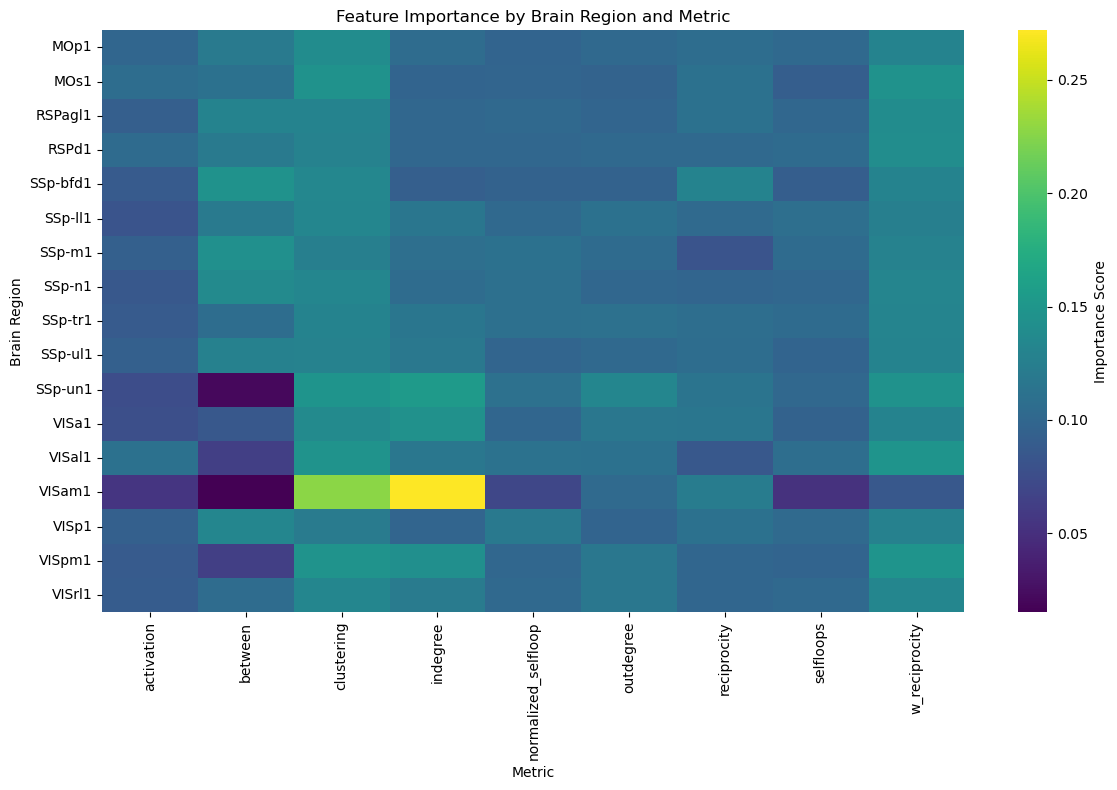

In [209]:
# Convert nested dict to DataFrame
df_scores = pd.DataFrame(top_features).T  # transpose so rows = regions, columns = metrics

# Optional: sort rows/columns if needed
df_scores = df_scores.sort_index(axis=0)  # sort brain regions
df_scores = df_scores.sort_index(axis=1)  # sort metrics

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df_scores, cmap='viridis', annot=False, cbar_kws={'label': 'Importance Score'})
plt.title('Feature Importance by Brain Region and Metric')
plt.xlabel('Metric')
plt.ylabel('Brain Region')
plt.tight_layout()
save_dir = my.check_if_dir_exists(str(result_dir / 'individual') +'/figures/')
plt.savefig(save_dir + 'FeatureImportance.png')

In [307]:

#make the FCs into gml

def average_hemisphere_graphs(G_left, G_right):
    # 1. Find common nodes
    common_nodes = set(G_left.nodes).intersection(set(G_right.nodes))

    # 2. Create averaged graph
    G_avg = nx.Graph()

    # 3. Average edges
    for src in common_nodes:
        for tgt in common_nodes:
            #if src == tgt:
            #    continue

            w_left = G_left[src][tgt]['weight'] if G_left.has_edge(src, tgt) else 0
            w_right = G_right[src][tgt]['weight'] if G_right.has_edge(src, tgt) else 0
            avg_weight = (w_left + w_right) / 2

            if avg_weight > 0:
                G_avg.add_edge(src, tgt, weight=avg_weight)

    return G_avg

#load allen atlas
allen_df = pd.read_csv('/home/dcuric/Documents/calciumAnalysis/codes/auxfiles/allen_subnetworks.csv')
regions = list(allen_df['labels'].values)
# Step 1: Create a mapping from label to index
label_to_index = dict(zip(allen_df['labels'], allen_df['roi']))

label_to_index = {x.replace('left', 'L').replace('right', 'R'): label_to_index[x] for x in label_to_index.keys()}
regions = [x.replace('left', 'L').replace('right', 'R') for x in regions]

#load fcc
# Loop over subjects
for i, subject_file in enumerate(subject_jsons):
    #try:
    with open(subject_file, 'r') as f:
        subject_json = json.load(f)

    path_name = subject_json['init']['project_root'] + subject_json['init']['derivative_path']
    fname = subject_json['len_control_FC']['name']

    fc = pd.read_csv(path_name + fname, sep=',', header=None)
    fc = fc.values
    
    G = nx.Graph()
    G.add_nodes_from(regions)

    edges_to_remove = []

    #mapping = dict()
    #for node in G.nodes():
        #mapping[node] = node.replace('left', 'L').replace('right', 'R')
    #G = nx.relabel_nodes(G, mapping)

    
    # Step 2: Loop over node pairs (upper triangle only, since fc is symmetric)
    nodes = list(G.nodes)
    for i, u in enumerate(nodes):
        for j in range(i + 1, len(nodes)):
            v = nodes[j]

            #if the nodes belong to different hemispheres don't connect them. 
            if u[-1] != v[-1]:
                continue
            
            if u in label_to_index and v in label_to_index:
                idx_u = label_to_index[u]-1
                idx_v = label_to_index[v]-1
                
                weight = fc[idx_u, idx_v]
                if not np.isnan(weight):
                    G.add_edge(u, v, weight=weight)
            else:
                print(f"Skipping pair ({u}, {v}): one or both nodes not found in allen_regions")

    LRnodes = {'L':list(), 'R': list()}
    for node in G.nodes():
        LRnodes[node[-1]].append(node)

    GL = G.subgraph(LRnodes['L'])
    GR = G.subgraph(LRnodes['R'])

    GL = nx.relabel_nodes(GL, {node: node[0:-1].strip() for node in GL.nodes()})
    GR = nx.relabel_nodes(GR, {node: node[0:-1].strip() for node in GR.nodes()})

    G = average_hemisphere_graphs(GL, GR)

    subject_json['len_control_FC']['gml'] = 'FC_len_control.gml'
    nx.write_gml(G, path_name + '/' +  subject_json['len_control_FC']['gml'])

    with open(subject_file, 'w') as f:
        json.dump(subject_json, f)

    

    #FOR TOMORROW: average weights into one component
    #for k,row in allen_df.iterrows():
        
    

NameError: name 'stop' is not defined

In [311]:
G.nodes()

NodeView(('MOp1', 'RSPagl1', 'MOs1', 'VISl1', 'SSs1', 'FRP1', 'SSp-tr1', 'AUDd1', 'SSp-un1', 'SSp-bfd1', 'AUDpo1', 'VISal1', 'SSp-ll1', 'SSp-m1', 'SSp-ul1', 'ACAd1', 'RSPd1', 'VISrl1', 'AUDp1', 'SSp-n1', 'VISam1', 'VISp1', 'VISa1', 'MOB', 'VISli1', 'VISpm1', 'PL1', 'RSPv1', 'VISpl1', 'TEa1', 'VISpor1'))

In [7]:
#compare FCs to ENs
# Loop over subjects
#collect node stats into dataframe
map_type = 'act_map'
need_step = map_type + '_event_graph'
graphs = dict()
for i, subject_file in enumerate(subject_jsons):
    #try:
    with open(subject_file, 'r') as f:
        subject_json = json.load(f)

    path_name = subject_json['init']['project_root'] + subject_json['init']['derivative_path']

     # Load nodes
    try :
        en_name = subject_json[need_step]['thresh=' + str(thresh)]['left_right_avgd']
        fc_name = subject_json['len_control_FC']['gml']
    except:
        print('need_step likely does not exist, i = ' + str(i))
        continue
        

    G = nx.read_gml(path_name + '/' + en_name + '.gml')
    F = nx.read_gml(path_name + '/' + fc_name)
    
    # Extract label
    condition = subject_json['init']['condition']
    if 'cohort' in condition:
        condition = re.sub(r'_cohort\d+', '', condition)

    graphs[i] = {'condition': condition, 'FC': F, 'EN': G}

df = pd.DataFrame(graphs).T
df.shape
    

(381, 3)

In [828]:
df['condition'].unique()

array(['Acute_PostShock', 'Acute_Baseline', 'Acute_Post24Hr',
       'Homecage Ctrl_Post1Hr', 'Homecage Ctrl_PostHomecage',
       'Homecage Ctrl_Baseline', 'Homecage Ctrl_Post24Hr',
       'Chronic_Post1Hr', 'Chronic_PostShock', 'Chronic_Baseline',
       'Chronic_Post24Hr', 'ChronicKet_Post1Hr', 'ChronicKet_PostShock',
       'ChronicKet_Baseline', 'ChronicKet_24Hours', 'Acute_Post1Hr',
       'Nov.Env.Ctrl_Post1Hr', 'Nov.Env.Ctrl_PostNov.Env.',
       'Nov.Env.Ctrl_Baseline', 'Nov.Env.Ctrl_Post24Hr'], dtype=object)

In [421]:
ref = project['reference_condition']
#ref = 'Chronic_PostShock'
df_sub = df[df['condition'].str.contains('Baseline')]# == ref]
#df_sub = df[df['condition'].str.contains('Acute_PostShock')]# == ref]
from scipy.special import softmax
import seaborn as sns

edge_comparison_df = pd.DataFrame(columns = ['idx', 'src', 'trg', 'FCw', 'ENw'])
for i,row in df_sub.iterrows():
    G = row['EN']
    F = row['FC']

    common_nodes = set(G.nodes).intersection(set(F.nodes))

    area = nx.get_node_attributes(G,'area')
    activation = nx.get_node_attributes(G, 'activation')
    
    for m, u in enumerate(common_nodes):
        for n,v in enumerate(common_nodes):
            if u == v:
                continue
                
            if G.has_edge(u,v) and F.has_edge(u,v):
                we = (G[u][v]['weight'])/area[u]**0/activation[u]**1
                wf = (F[u][v]['weight'])
            elif not G.has_edge(u,v) and F.has_edge(u,v):
                we = (0)
                wf = (F[u][v]['weight'])
            elif G.has_edge(u,v) and not F.has_edge(u,v):
                we = (G[u][v]['weight'])/area[u]**0/activation[u]**1
                wf = (0)
            else:
                we = 0
                wf = 0

            row = {'idx': i, 'src': u, 'trg': v, 'FCw': wf, 'ENw': we}
            row = pd.DataFrame(row, index=[0])

            edge_comparison_df = pd.concat([edge_comparison_df, row], ignore_index=True)

            
edge_comparison_df['ENw_norm'] = edge_comparison_df['ENw']/edge_comparison_df['ENw'].max() + 10**-5
edge_comparison_df['FCw'] += 10**-5

edge_comparison_df['ENw_sftmx'] = softmax(np.array(list(edge_comparison_df['ENw'].values)))
edge_comparison_df['FCw_sftmx'] = softmax(np.array(list(edge_comparison_df['FCw'].values)))

/tmp/ipykernel_694819/2932978871.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_comparison_df = pd.concat([edge_comparison_df, row], ignore_index=True)


In [840]:
df_sub.shape

(97, 3)

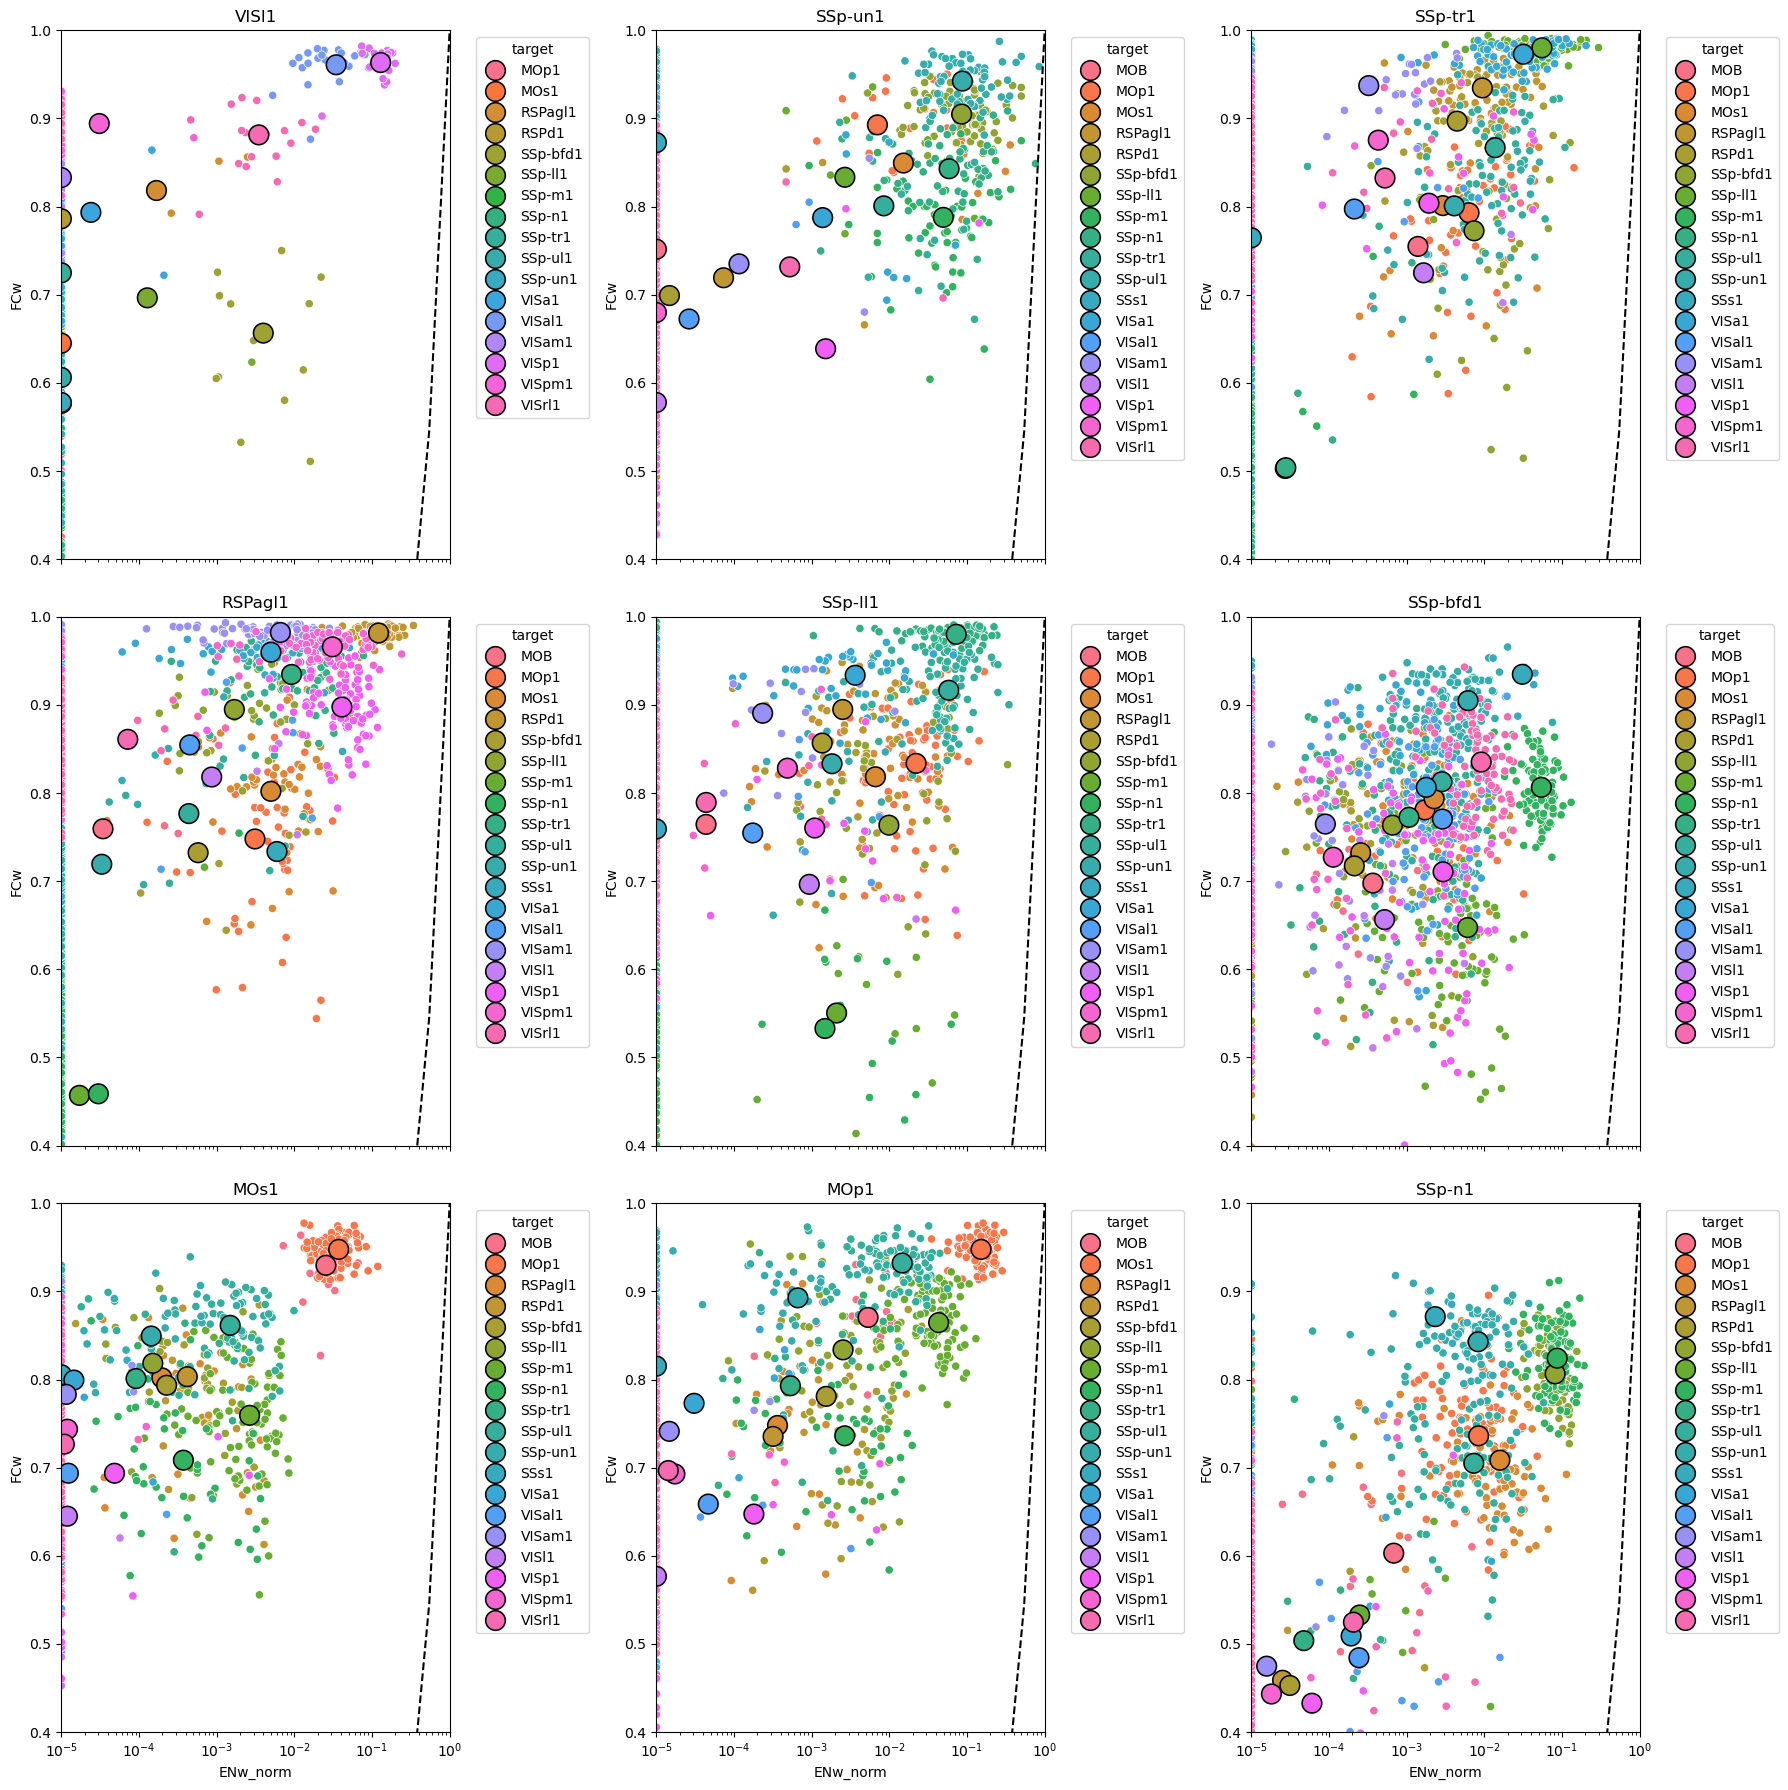

In [425]:
# Assume your DataFrame is called df
nodeslist = list(G.nodes())
xlims = 10**np.linspace(-5, 0, 20)#np.array([0.0001,0.1,1])

fac = 6
ncols = 3
nrows = 3


fig, axes = plt.subplots(nrows,ncols, sharex=True, figsize=(fac*ncols, fac*nrows))

axes = axes.flatten()

for k in range(9):
    data = edge_comparison_df[edge_comparison_df['src'] == nodeslist[k]];
    data = data.sort_values(by = ['trg'])
    
    ax = sns.scatterplot(ax = axes[k], data= data, x='ENw_norm', y='FCw', hue='trg', palette='husl')  # or 'Set2', 'husl', etc.
    
    data = data.groupby('trg', as_index=False)[['ENw_norm', 'FCw']].mean()
    data = data.sort_values(by = ['trg'])
    
    ax = sns.scatterplot(ax = ax, data= data, x='ENw_norm', y='FCw', hue='trg', palette='husl', s=200, edgecolor = 'k')  # or 'Set2', 'husl', etc.
    
    ax.set(xscale="log")
    
    ax.plot(xlims, xlims, '--k')
    ax.set(xlim = xlims[[0,len(xlims)-1]])
    ax.set(ylim = [0.4,1])
    ax.set_title(nodeslist[k])

    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 4 each.
    handles, labels = ax.get_legend_handles_labels()
    L = len(handles)
    
    
    ax.legend(handles[int(L/2):L], labels[int(L/2):L], title='target', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

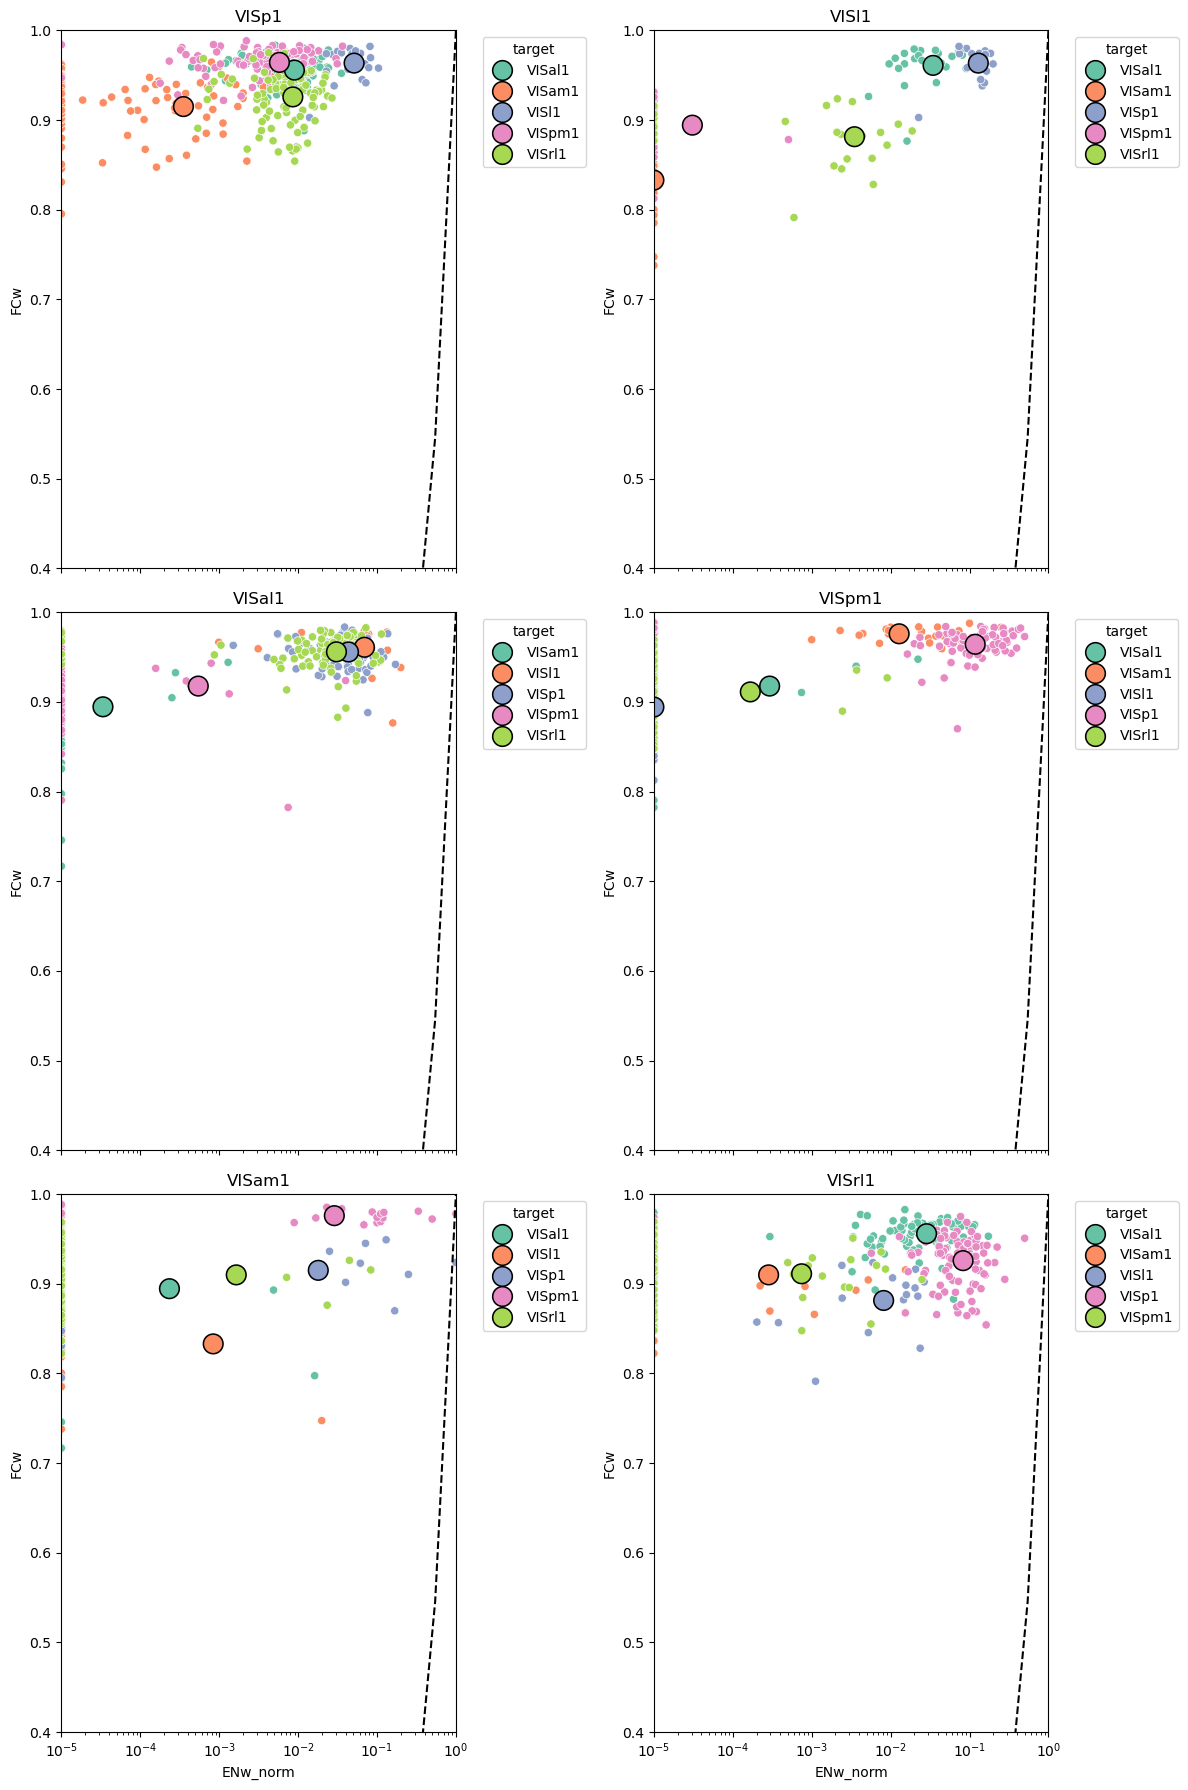

In [1220]:
vishier= ['VISp1', 'VISl1','VISal1',  'VISpm1', 'VISam1','VISrl1']

xlims = 10**np.linspace(-5, 0, 20)#np.array([0.0001,0.1,1])

fac = 6
ncols = 2
nrows = 3


fig, axes = plt.subplots(nrows,ncols, sharex=True, figsize=(fac*ncols, fac*nrows))

axes = axes.flatten()

for k,node in enumerate(vishier):
    data = edge_comparison_df[edge_comparison_df['src'] == node];

    mask = data['trg'].isin(vishier)
    data = data[mask]
    
    data = data.sort_values(by = ['trg'])
    
    ax = sns.scatterplot(ax = axes[k], data= data, x='ENw_norm', y='FCw', hue='trg', palette='Set2')  # or 'Set2', 'husl', etc.
    
    data = data.groupby('trg', as_index=False)[['ENw_norm', 'FCw']].mean()
    data = data.sort_values(by = ['trg'])
    
    ax = sns.scatterplot(ax = ax, data= data, x='ENw_norm', y='FCw', hue='trg', palette='Set2', s=200, edgecolor = 'k')  # or 'Set2', 'husl', etc.
    
    ax.set(xscale="log")
    
    ax.plot(xlims, xlims, '--k')
    ax.set(xlim = xlims[[0,len(xlims)-1]])
    ax.set(ylim = [0.4,1])
    ax.set_title(node)

    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 4 each.
    handles, labels = ax.get_legend_handles_labels()
    L = len(handles)
    
    
    ax.legend(handles[int(L/2):L], labels[int(L/2):L], title='target', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()



In [27]:
print(list(G.nodes()))

['VISl1', 'SSp-un1', 'SSp-tr1', 'RSPagl1', 'SSp-ll1', 'SSp-bfd1', 'MOs1', 'MOp1', 'SSp-n1', 'VISp1', 'VISa1', 'RSPd1', 'VISam1', 'SSp-ul1', 'VISpm1', 'VISrl1', 'VISal1', 'SSp-m1']


In [431]:
def create_graph(adj_matrix):
    G = nx.MultiDiGraph()
    G.add_nodes_from(CORTEX)
    for index, i in enumerate(CORTEX):
        for jndex, j in enumerate(CORTEX):
            if i == j:
                continue
            weight = adj_matrix[index, jndex]
            G.add_edge(i, j, weight=weight)
    return G

def scale_matrix(matrix, min_new, max_new):
    cleaned_mat   = matrix[~np.isnan(matrix)]
    scaled_matrix = (matrix - np.min(cleaned_mat)) * (max_new - min_new) / (np.max(cleaned_mat) - np.min(cleaned_mat)) + min_new
    return scaled_matrix

import math
#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["font.size"]   = 12

cortex = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl']#, 'SSp-n', 'SSp-tr','SSp-ll', 'SSp-bfd', 'SSp-n','SSp-ul','SSp-m']#, 'CA1', 'LP', 'APN']

cortex= list(G.nodes())
cortex = [x[0:-1] for x in cortex]
cortex.sort()

#cortex = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl']

df_structure = pd.read_excel('/home/dcuric/Documents/calciumAnalysis/codes/auxfiles/41586_2019_1716_MOESM5_ESM.xlsx', sheet_name='all CC connection strengths')

df_structure= df_structure[(df_structure['hemisphere']=='ipsi')]# & (df_structure['Mouse Line']=='Rbp4-Cre_KL100')]#'C57BL/6J / Emx1')]

#scortex = ['VISp-1', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl']

CC_connectivity = np.zeros((len(cortex),len(cortex)))
for sndex, source in enumerate(cortex):
    for tndex, target in enumerate(cortex):
        if sndex == tndex:
            CC_connectivity[sndex, tndex] = np.nan
            continue
        CC_connectivity[sndex, tndex] = df_structure[(df_structure['Exp Source']==source) & (df_structure['Target']==target)]['NPV (online)'].mean()
        #if math.isnan(CC_connectivity[sndex, tndex]):
            #stop
adj_mat = CC_connectivity
#adj_mat = scale_matrix(CC_connectivity, 5, 17)


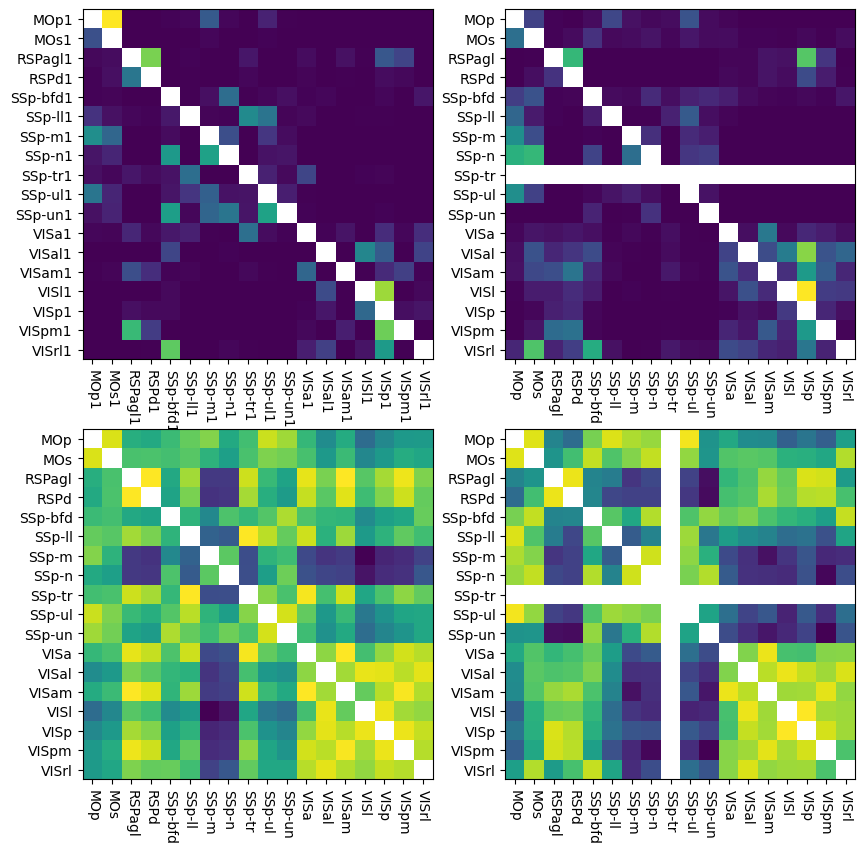

In [451]:
vishier= list(G.nodes())#['VISp1', 'VISl1','VISal1',  'VISpm1', 'VISam1','VISrl1']
#vishier = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl']
vishier.sort()
L = len(vishier)
ed_df= edge_comparison_df.copy()


A_EN = np.zeros([L,L])
A_FC = np.zeros([L,L])

for i,u in enumerate(vishier):
    for j,v in enumerate(vishier):
        row = ed_df[(ed_df['src'] == u) & (ed_df['trg'] == v)]
        A_EN[i,j] = row['ENw_norm'].mean()
        A_FC[i,j] = row['FCw'].mean()

        #sanity check for plot
        #if i == 3 and j == 4:
        #    A_EN[i,j] = 7


#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in A_EN]))
#print('')
#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in A_FC]))

f, axes = plt.subplots(2, 2, figsize = (10,10))

#plt.figure()

ax = axes[0,0]
plt.sca(ax)
plt.imshow((A_EN))
plt.yticks(ticks=np.arange(len(cortex)), labels=vishier);
plt.xticks(ticks=np.arange(len(cortex)), labels=vishier, rotation=-90);

ax = axes[1,0]
plt.sca(ax)
plt.imshow((A_FC))
plt.yticks(ticks=np.arange(len(cortex)), labels=cortex);
plt.xticks(ticks=np.arange(len(cortex)), labels=cortex, rotation=-90);
A_EN.tofile(project['calcium_analysis_root'] + 'directedNetwork.csv',sep=',',format='%10.5f')

ax = axes[0,1]
plt.sca(ax)
plt.imshow(adj_mat)
plt.yticks(ticks=np.arange(len(cortex)), labels=cortex);
plt.xticks(ticks=np.arange(len(cortex)), labels=cortex, rotation=-90);

ax = axes[1,1]
plt.sca(ax)
fc = np.log10(adj_mat)
fc += np.transpose(fc)
plt.imshow(fc)
plt.yticks(ticks=np.arange(len(cortex)), labels=cortex);
plt.xticks(ticks=np.arange(len(cortex)), labels=cortex, rotation=-90);

PearsonRResult(statistic=0.6158251212000245, pvalue=1.462963539163849e-31)


Text(0, 0.5, 'Mine')

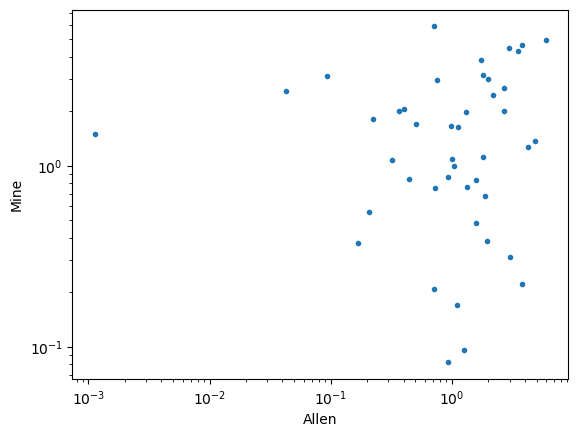

In [445]:
from scipy import stats

mask = np.isfinite(adj_mat)
adj_vals = adj_mat[mask]
A_ENvals = A_EN[mask]

adj_vals = (adj_vals - np.mean(adj_vals))/np.std(adj_vals)
A_ENvals= (A_ENvals - np.mean(A_ENvals))/np.std(A_ENvals)

rho = stats.pearsonr(adj_vals, A_ENvals)
print(rho)

plt.loglog(adj_vals, A_ENvals, '.')
plt.xlabel('Allen')
plt.ylabel('Mine')

PearsonRResult(statistic=0.7262416992349374, pvalue=7.527612003099901e-46)


Text(0, 0.5, 'Mine')

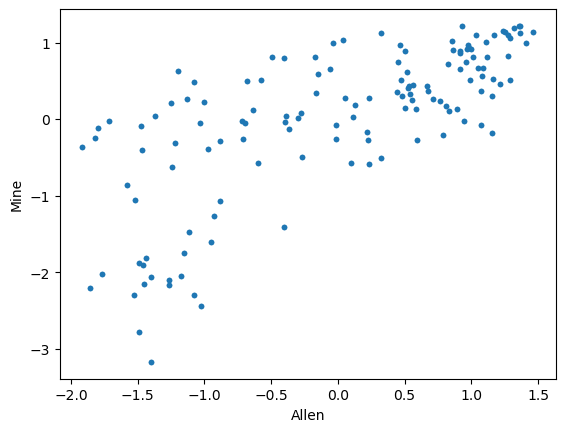

In [447]:
mask = np.isfinite(fc)
fc_vals = fc[mask]
A_FNvals = np.log10(A_FC[mask])

fc_vals = (fc_vals - np.mean(fc_vals))/np.std(fc_vals)
A_ENvals= (A_FNvals- np.mean(A_FNvals))/np.std(A_FNvals)

rho = stats.pearsonr(fc_vals, A_ENvals)
print(rho)

plt.plot(fc_vals, A_ENvals, '.')
plt.xlabel('Allen')
plt.ylabel('Mine')

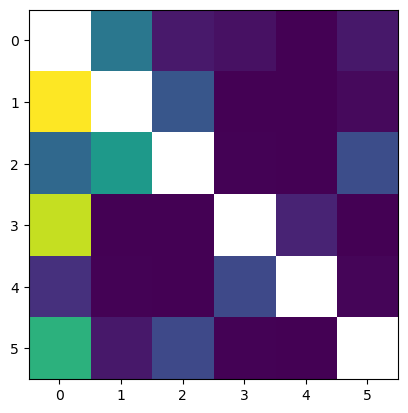

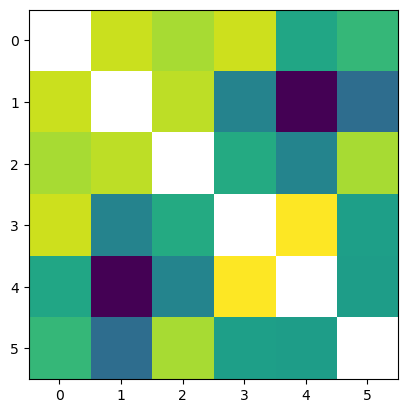

In [151]:
vishier= ['VISp1', 'VISl1','VISal1',  'VISpm1', 'VISam1','VISrl1']

L = len(vishier)
ed_df= edge_comparison_df.copy()


A_EN = np.zeros([L,L])
A_FC = np.zeros([L,L])

for i,u in enumerate(vishier):
    for j,v in enumerate(vishier):
        row = ed_df[(ed_df['src'] == u) & (ed_df['trg'] == v)]
        A_EN[i,j] = row['ENw_norm'].mean()
        A_FC[i,j] = row['FCw'].mean()

        #sanity check for plot
        #if i == 3 and j == 4:
        #    A_EN[i,j] = 7


#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in A_EN]))
#print('')
#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in A_FC]))

plt.figure()
plt.imshow((A_EN))

plt.figure()
plt.imshow(np.log10(A_FC))

A_EN.tofile(project['calcium_analysis_root'] + 'directedNetwork.csv',sep=',',format='%10.5f')

In [956]:
temp = pd.DataFrame(A_EN)
temp.to_csv(project['calcium_analysis_root'] + 'directedNetwork.csv')

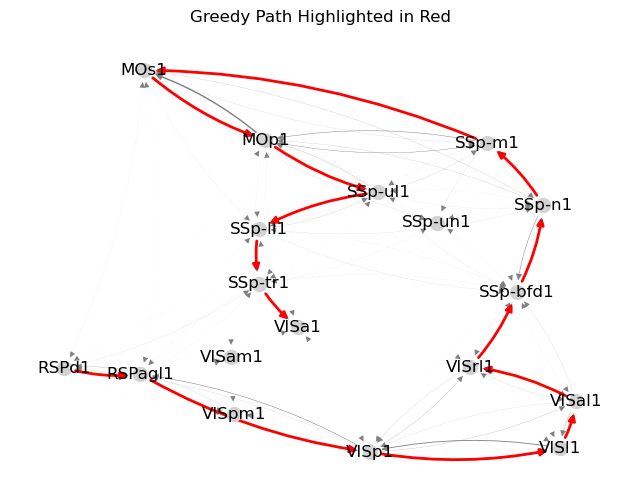

In [1076]:

def plot_greedy_path(G, path):
    pos = {node: G.nodes[node]['pos'] for node in G.nodes}
    pos = {x : -1*np.array(pos[x]) for x in pos.keys()}
    
    # Set up edge widths scaled by weight
    all_edges = list(G.edges(data=True))
    edge_widths = [data['weight'] for _, _, data in all_edges]

    # Draw full graph
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=100)
    nx.draw_networkx_labels(G, pos)

    # Draw all edges with scaled width
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v) for u, v, _ in all_edges],
        width=np.array(edge_widths)*0.1,
        edge_color='gray',
        arrows=True,
        arrowstyle='-|>',
        connectionstyle='arc3,rad=0.1'
    )

    # Draw greedy path with highlighted style
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(
        G, pos,
        edgelist=path_edges,
        width=2,
        edge_color='red',
        arrows=True,
        arrowstyle='-|>',
        connectionstyle='arc3,rad=0.1'
    )

    plt.axis('off')
    plt.title('Greedy Path Highlighted in Red')
    plt.show()
    
def greedy_path(G, nodelist, u):
    visited = set()
    path = [u]
    current = u
    visited.add(current)

    while True:
        # Get outgoing edges from current node that lead to unvisited nodes
        neighbors = [(v, G[current][v]['weight']) for v in G.successors(current) if v not in visited]
        if not neighbors:
            break  # no unvisited neighbors left

        # Choose the neighbor with maximum weight
        next_node = max(neighbors, key=lambda x: x[1])[0]

        path.append(next_node)
        visited.add(next_node)
        current = next_node

    return path

def greedy_path_allow_loops(G, nodelist, u):
    path = [u]

    while True:
        current = path[-1]
        # Get outgoing edges to any neighbor
        neighbors = [(v, G[current][v]['weight']) for v in G.successors(current)]

        # Filter out direct backtracking (no u > v > u)
        if len(path) >= 2:
            prev = path[-2]
            neighbors = [item for item in neighbors if item[0] != prev]

        if not neighbors:
            break

        # Pick highest-weight neighbor
        next_node = max(neighbors, key=lambda x: x[1])[0]

        if next_node in path:
            # loop detected — stop
            path.append(next_node)
            break

        path.append(next_node)

    return path

G.remove_edges_from(nx.selfloop_edges(G))
nodelist = list(G.nodes())
path = greedy_path(G, nodelist, nodelist[11])
plot_greedy_path(G, path)

In [1036]:
path

['SSp-un1']

In [197]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named `df` and you want to start from component k1:
def plot_pca_by_condition(df, k1=0):
    # Drop non-numeric or irrelevant columns
    features = df.select_dtypes(include=['float64', 'int']).copy()
    # Optional: drop the index column if it's present as a column, not the DataFrame index
    if 'index' in features.columns:
        features = features.drop(columns='index')

    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(features)
    
    # Create a new DataFrame with the selected PCA dimensions
    pca_df = pd.DataFrame({
        f'PC{k1+1}': pca_result[:, k1],
        f'PC{k1+2}': pca_result[:, k1 + 1],
        'condition': df['condition']
    })

    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=pca_df,
        x=f'PC{k1+1}',
        y=f'PC{k1+2}',
        hue='condition',
        palette='Set2',
        s=70
    )
    plt.title(f'PCA Projection: PC{k1+1} vs PC{k1+2}')
    plt.xlabel(f'Principal Component {k1+1}')
    plt.ylabel(f'Principal Component {k1+2}')
    plt.legend(title='Condition')
    plt.tight_layout()
    plt.show()

plot_pca_by_condition(node_df[(node_df['Brain Region'] == 'VISam1')],k1 = 0)# & (stats['condition'].str.contains('Chronic'))], k1=0)



ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [203]:
node_df[(node_df['Brain Region'] == 'VISam1')].head(250)

activation  selfloops  indegree  outdegree  between  clustering  \
12           3.0   0.000000  1.713326   2.916667      0.0    0.001109   
29           1.0   1.000000  1.895103   1.000000      0.0    0.000630   
47           0.0   0.000000  0.746795   0.000000      0.0    0.003403   
65           1.5   0.000000  1.682483   1.500000      0.0    0.000452   
85           1.5   1.500000  2.102420   1.500000      0.0    0.000959   
...          ...        ...       ...        ...      ...         ...   
4314         1.0   0.000000  1.352689   1.000000      0.0    0.000558   
4331         1.5   1.500000  2.480563   1.500000      0.0    0.000836   
4349         1.5   1.166667  1.732091   1.416667      0.0    0.000455   
4366         3.0   1.979167  2.290438   2.687500      0.0    0.000386   
4382         0.5   0.000000  0.799285   0.500000      0.0    0.000374   

      reciprocity  w_reciprocity Brain Region        condition  \
12       0.909091       0.282946       VISam1  Acute_PostShock   
29       0.285714       0.000000       VISam1  Acute_PostShock   
47       0.000000       0.000000       VISam1  Acute_PostShock   
65       0.363636       0.038462       VISam1  Acute_PostShock   
85       0.400000       0.000000       VISam1  Acute_PostShock   
...           ...            ...          ...              ...   
4314     0.250000       0.000000       VISam1  Acute_PostShock   
4331     0.285714       0.000000       VISam1  Acute_PostShock   
4349     0.200000       0.000000       VISam1  Acute_PostShock   
4366     0.545455       0.049176       VISam1  Acute_PostShock   
4382     0.333333       0.000000       VISam1  Acute_PostShock   

      normalized_selfloop  
12               0.000000  
29               0.013245  
47               0.000000  
65               0.000000  
85               0.020979  
...                   ...  
4314             0.000000  
4331             0.020548  
4349             0.016908  
4366             0.028893  
4382             0.000000  

[250 rows x 11 columns]

In [182]:
with open(meta_file_dir + '/' + meta_file_name + '.pkl', 'rb') as f:
    meta = pickle.load(f)

load_name = map_type +  '_LRavgd_graph'
graphs = dict()
for key in meta[load_name].keys():
    G = nx.read_gml(meta[load_name][key]['path'] + '.' + meta[load_name][key]['format'])
    graphs[key] = G

In [283]:
#calculate properties for the nodes
save_name = 'nodedf'
save_dir = result_dir / 'individual_graphs/'
condition = list()
metrics = ['indegree' , 'outdegree', 'between', 'clustering', 'activation']
node_df = pd.DataFrame(columns = ['condition', 'node'] + metrics)
for key in graphs.keys():
    G = graphs[key]
    
    stats_df,G = my.calculate_node_proprties(G, key);
    node_df = pd.concat([node_df, stats_df]);
    graphs[key] = G

    cond = meta[map_type + '_event_graph'][key]['condition']
    condition.append([cond] * stats_df.shape[0])
    #update the graph meta
    meta[map_type +  '_LRavgd_graph'][key]['metrics'] = metrics

    #save the graph
    save_dir = meta[map_type +  '_LRavgd_graph'][key]['path']
    nx.write_gml(G, meta[map_type +  '_LRavgd_graph'][key]['path'] + '.' + meta[map_type +  '_LRavgd_graph'][key]['format'])


#save the node_df file
meta[save_name] = {'path': str(save_dir) + '/' + save_name,
                                    'save_dir': str(save_dir),
                                    'save_name': save_name,
                                    'format' : 'csv',
                                    'num_cols' : node_df.shape[1],
                                    'num_rows' : node_df.shape[0]
                                   }

#flatten condition
condition = [x for xs in condition for x in xs]

node_df = node_df.rename(columns = {'condition': 'index'})
node_df['condition'] = condition
node_df.to_csv(meta[save_name]['path'] + '.csv')


/tmp/ipykernel_63199/1461662362.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  node_df = pd.concat([node_df, stats_df]);


OSError: Cannot save file into a non-existent directory: '/home/dcuric/Documents/calciumAnalysis/event_based_networks/python/results/neumann/individual_graphs/graphs/recid=380_id=id_8d97f4d904e41f9c/act_map_LRavgd_graph'

In [265]:
node_df.head()
test_df = node_df[node_df['node'] == 'SSp-m1']

index    node   indegree  outdegree   between  clustering  activation  \
0     0  SSp-m1   7.024912   8.063773  0.327206    0.116393        33.0   
1     0   VISp1   7.372487  16.247464  0.411765    0.043507       167.0   
2     0   RSPd1   7.209790   5.522795  0.051471    0.025560        59.0   
3     0    MOp1  13.057553   9.885489  0.224265    0.050732        52.0   
4     0  VISrl1   5.101494   4.865195  0.305147    0.062616        12.0   

   reciprocity  w_reciprocity        condition  
0     0.909091       0.344864  Acute_PostShock  
1     0.736842       0.308744  Acute_PostShock  
2     0.526316       0.158042  Acute_PostShock  
3     0.842105       0.441957  Acute_PostShock  
4     0.600000       0.345799  Acute_PostShock

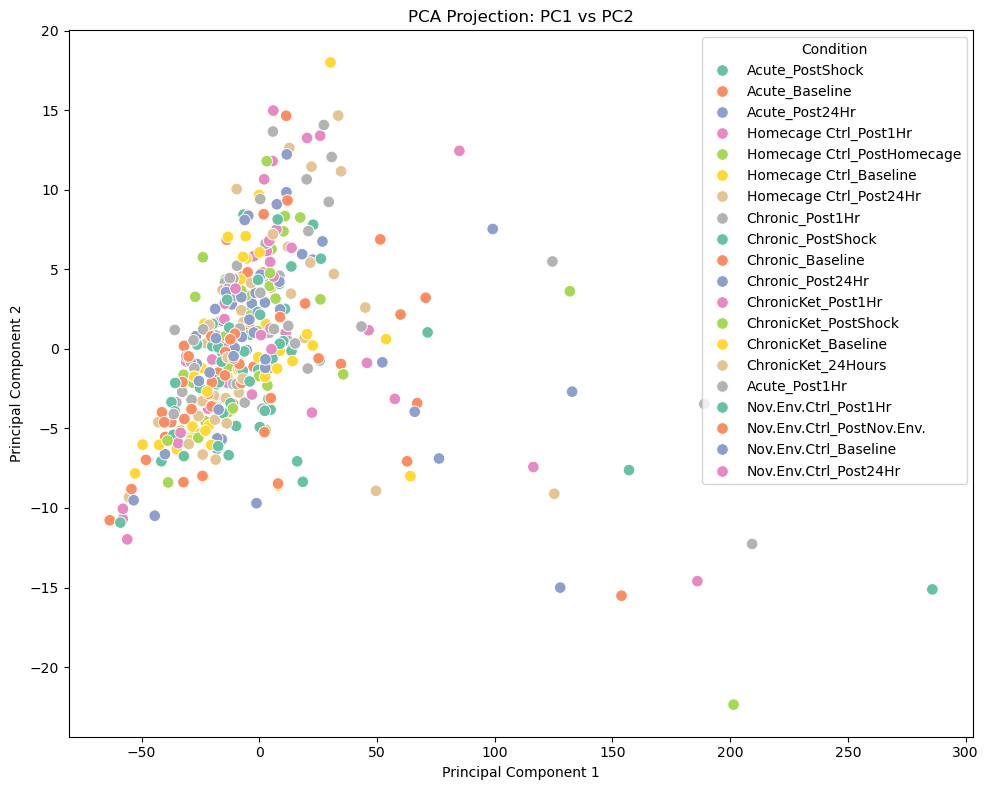

In [279]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named `df` and you want to start from component k1:
def plot_pca_by_condition(df, k1=0):
    # Drop non-numeric or irrelevant columns
    features = df.select_dtypes(include=['float64', 'int']).copy()
    # Optional: drop the index column if it's present as a column, not the DataFrame index
    if 'index' in features.columns:
        features = features.drop(columns='index')

    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(features)
    
    # Create a new DataFrame with the selected PCA dimensions
    pca_df = pd.DataFrame({
        f'PC{k1+1}': pca_result[:, k1],
        f'PC{k1+2}': pca_result[:, k1 + 1],
        'condition': df['condition']
    })

    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=pca_df,
        x=f'PC{k1+1}',
        y=f'PC{k1+2}',
        hue='condition',
        palette='Set2',
        s=70
    )
    plt.title(f'PCA Projection: PC{k1+1} vs PC{k1+2}')
    plt.xlabel(f'Principal Component {k1+1}')
    plt.ylabel(f'Principal Component {k1+2}')
    plt.legend(title='Condition')
    plt.tight_layout()
    plt.show()

plot_pca_by_condition(node_df[node_df['node'] == 'MOp1'], k1=0)

In [19]:
#calculate properties for the edges
save_name = 'edgedf'
save_dir = result_dir / 'averaged_graphs/'

conds = list(set(node_df['condition']))
edge_df = pd.DataFrame(columns = ['source_target'] + conds)
zero_factor = 10**-7

nodes = list(set(node_df['node']))

for c in conds:
    G = graphs[c]
    weight = list()
    st = list()
    for source in nodes:
        for target in nodes:
            st.append(source + '_' + target)
            if G.has_edge(source, target):
                weight.append(G[source][target]['weight'])
            else:
                weight.append(zero_factor)
                

    edge_df['source_target'] = st
    edge_df[c] = weight

            


#save the node_df file
avg_graphs_meta[save_name] = {'path': str(save_dir) + '/' + save_name,
                                    'save_dir': str(save_dir),
                                    'save_name': save_name,
                                    'format' : 'csv',
                                    'num_cols' : edge_df.shape[1],
                                    'num_rows' : edge_df.shape[0]
                                   }

edge_df.to_csv(avg_graphs_meta[save_name]['path'] + '.csv')


In [21]:
   
with open(str(result_dir / 'averaged_graphs') + '/' + 'avg_graphs_meta.pkl', 'wb') as f:
    pickle.dump(avg_graphs_meta, f) 

In [3]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

edge_df = pd.read_csv(avg_graphs_meta['edgedf']['path'] + '.csv')
node_df = pd.read_csv(avg_graphs_meta['nodedf']['path'] + '.csv')

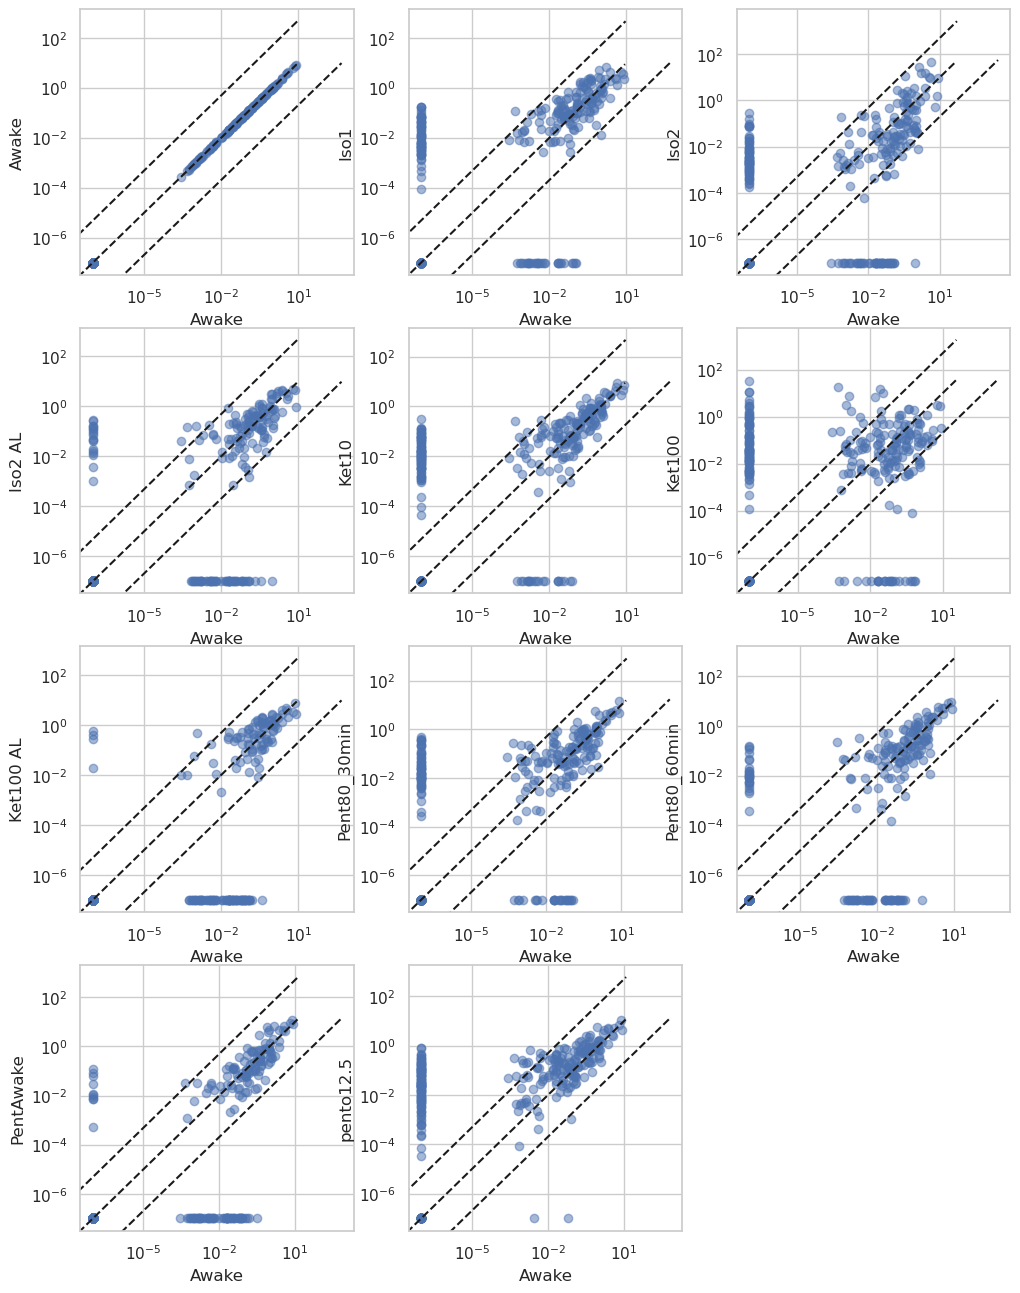

In [25]:
#plot weights against reference
conds = list(avg_graphs_meta['avg_graph'].keys())
ncols = int(np.ceil(3./4*np.sqrt(len(conds))))
nrows = int(np.ceil(4./3*np.sqrt(len(conds))))
count = 1
plt.figure(figsize = (ncols*4,nrows*4))
cond1 = reference 
cond1_weights = edge_df[cond1]



for j,cond2 in enumerate(conds):
    cond2_weights = edge_df[cond2]

    
    plt.subplot(nrows, ncols, count)
    count += 1
    plt.scatter(cond1_weights, cond2_weights, alpha = 0.5)
    my.plot_reference_line()
    my.plot_reference_line(slope = 50)
    my.plot_reference_line(slope = 1./50)
    plt.xscale('log')
    plt.yscale('log')
    #plt.title(cond1 + ' vs ' + cond2)
    plt.xlabel(cond1)
    plt.ylabel(cond2)
    ax = plt.gca()
    ax.get_legend().remove()

save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
plt.savefig(save_dir + 'weights_comparison_reference=' + reference +  '.png')

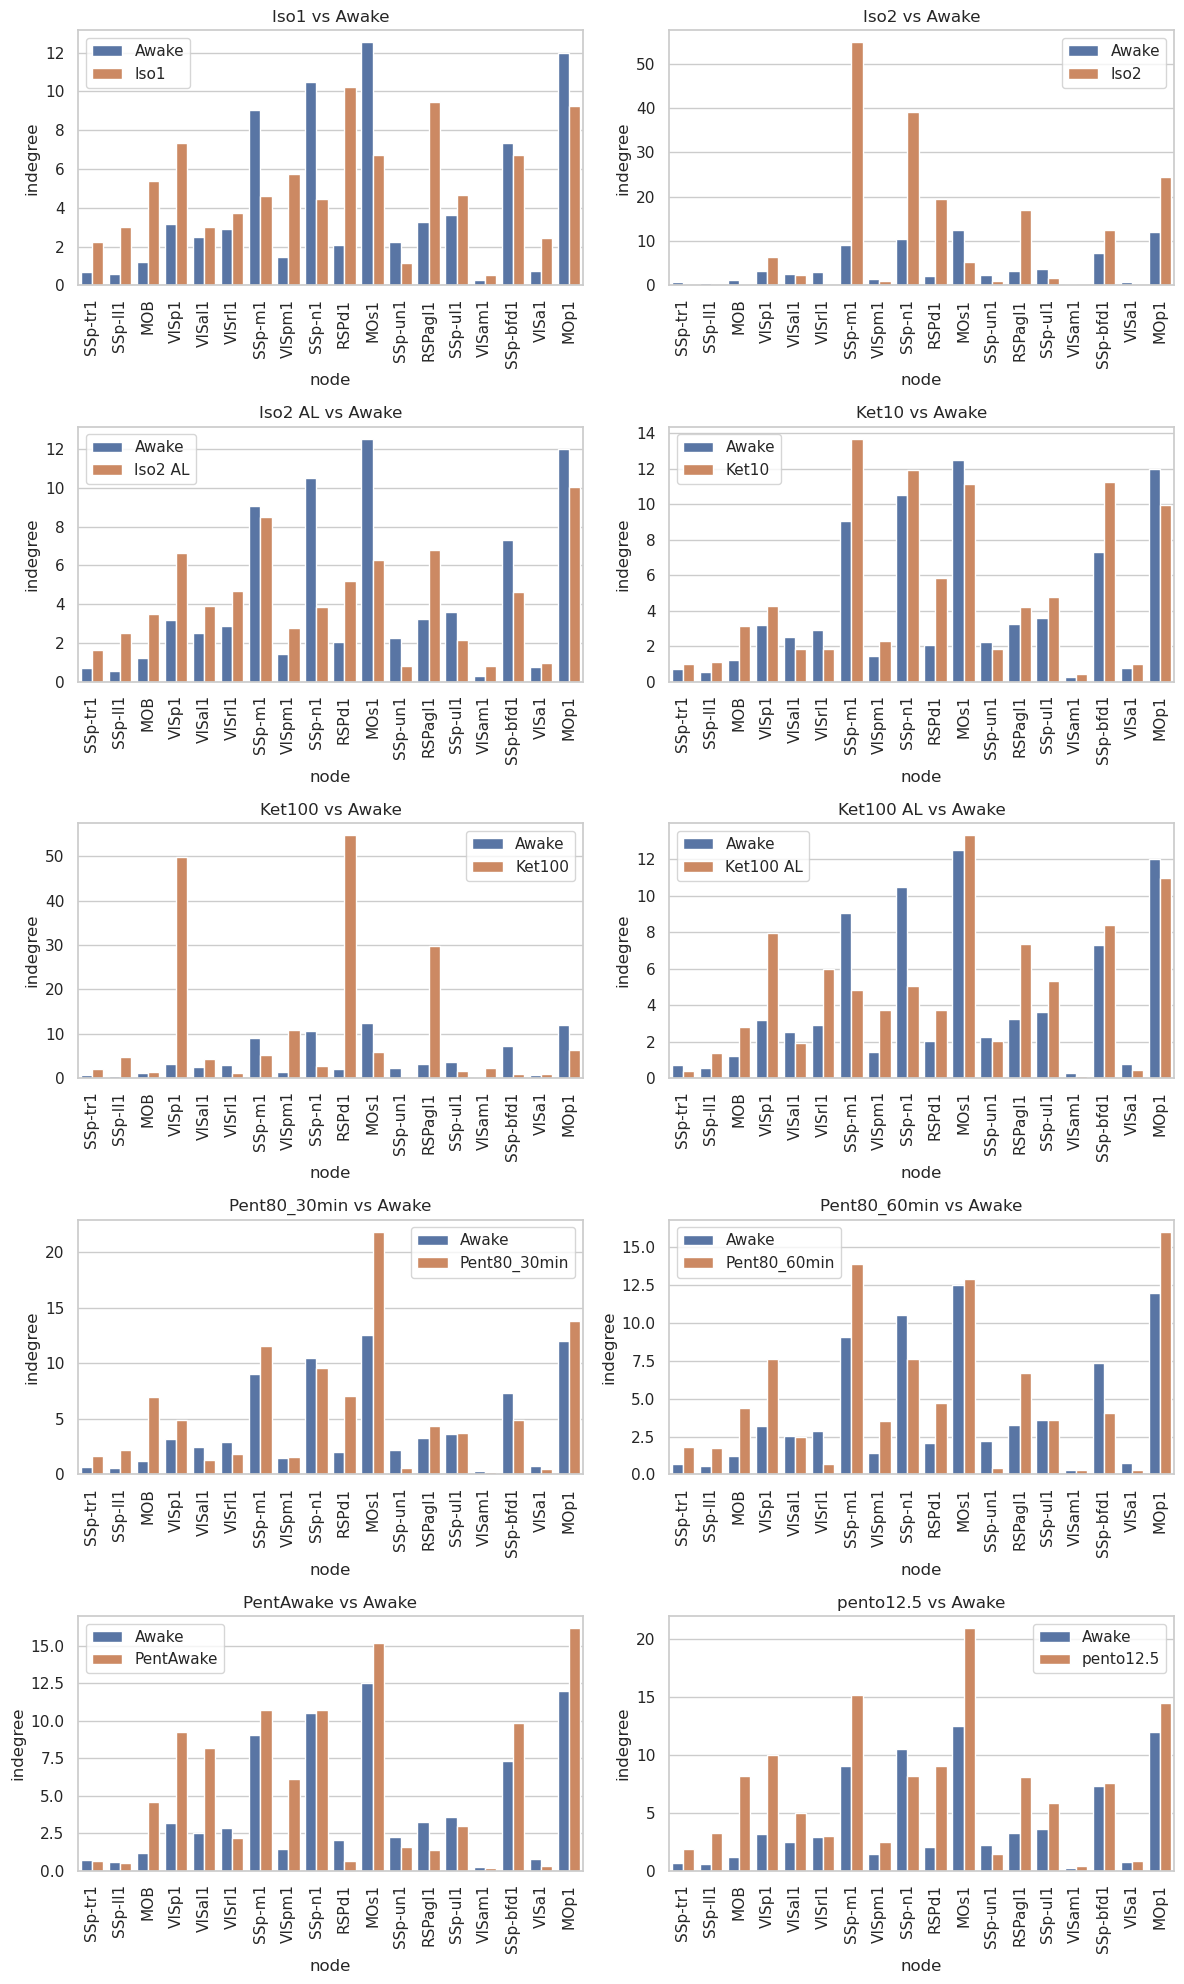

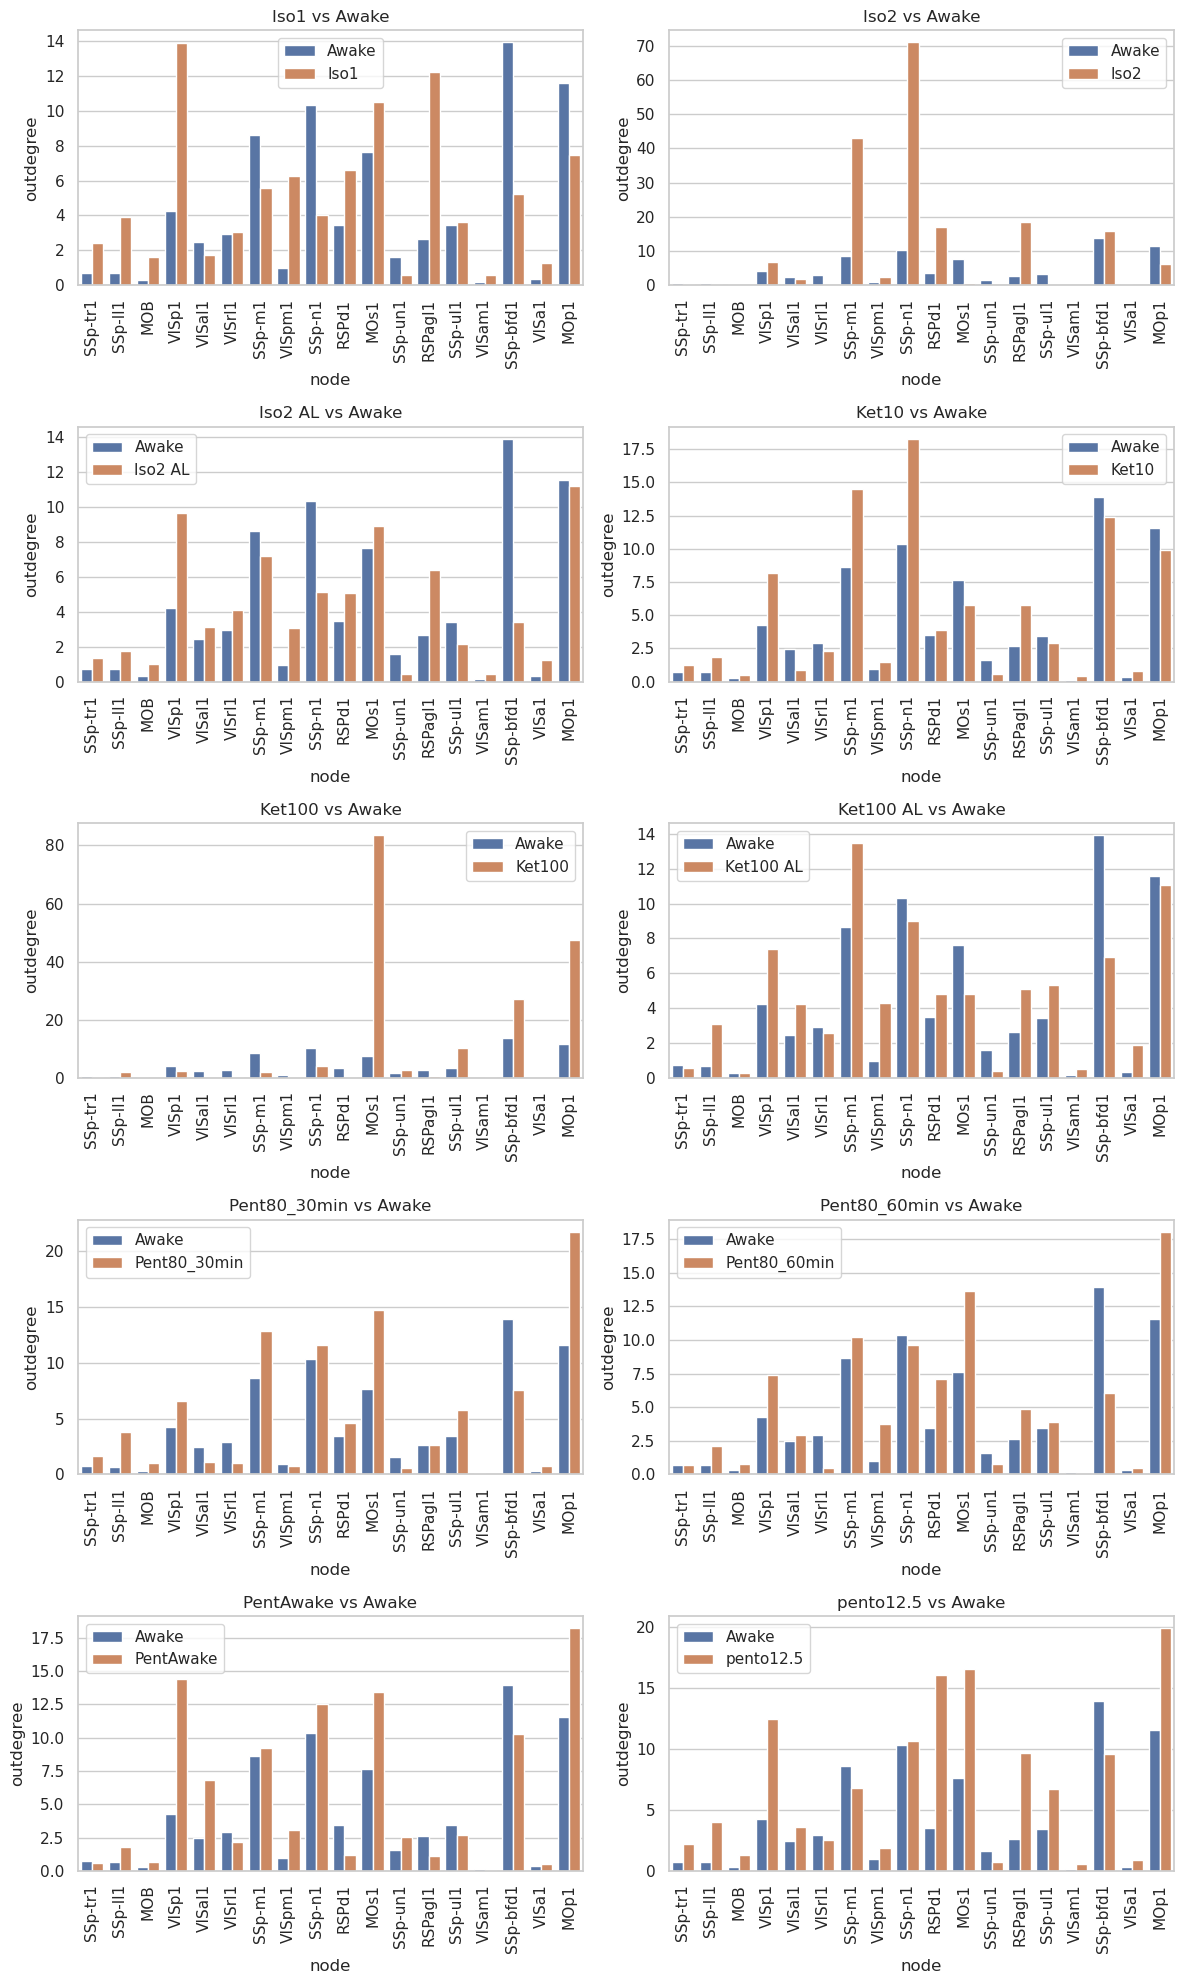

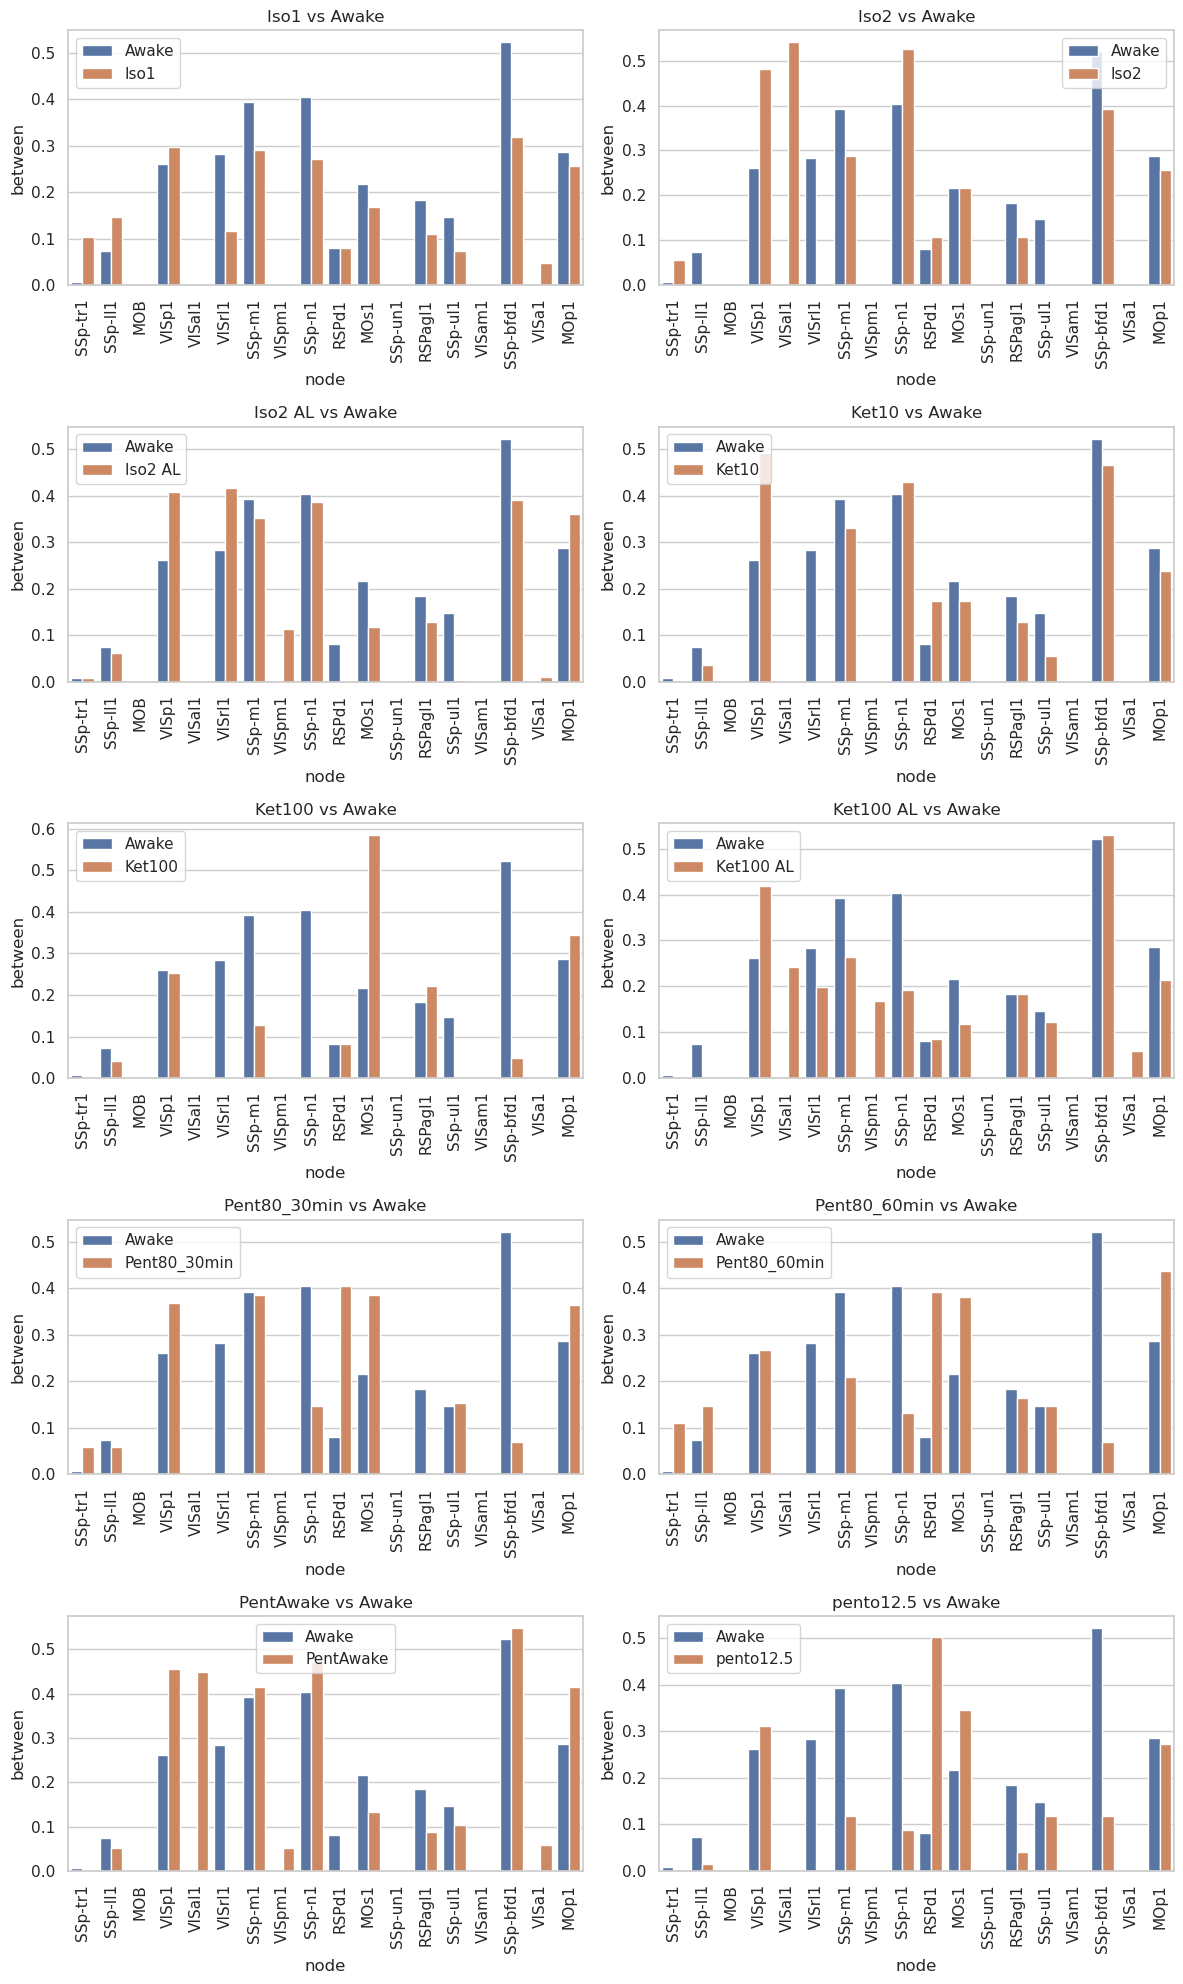

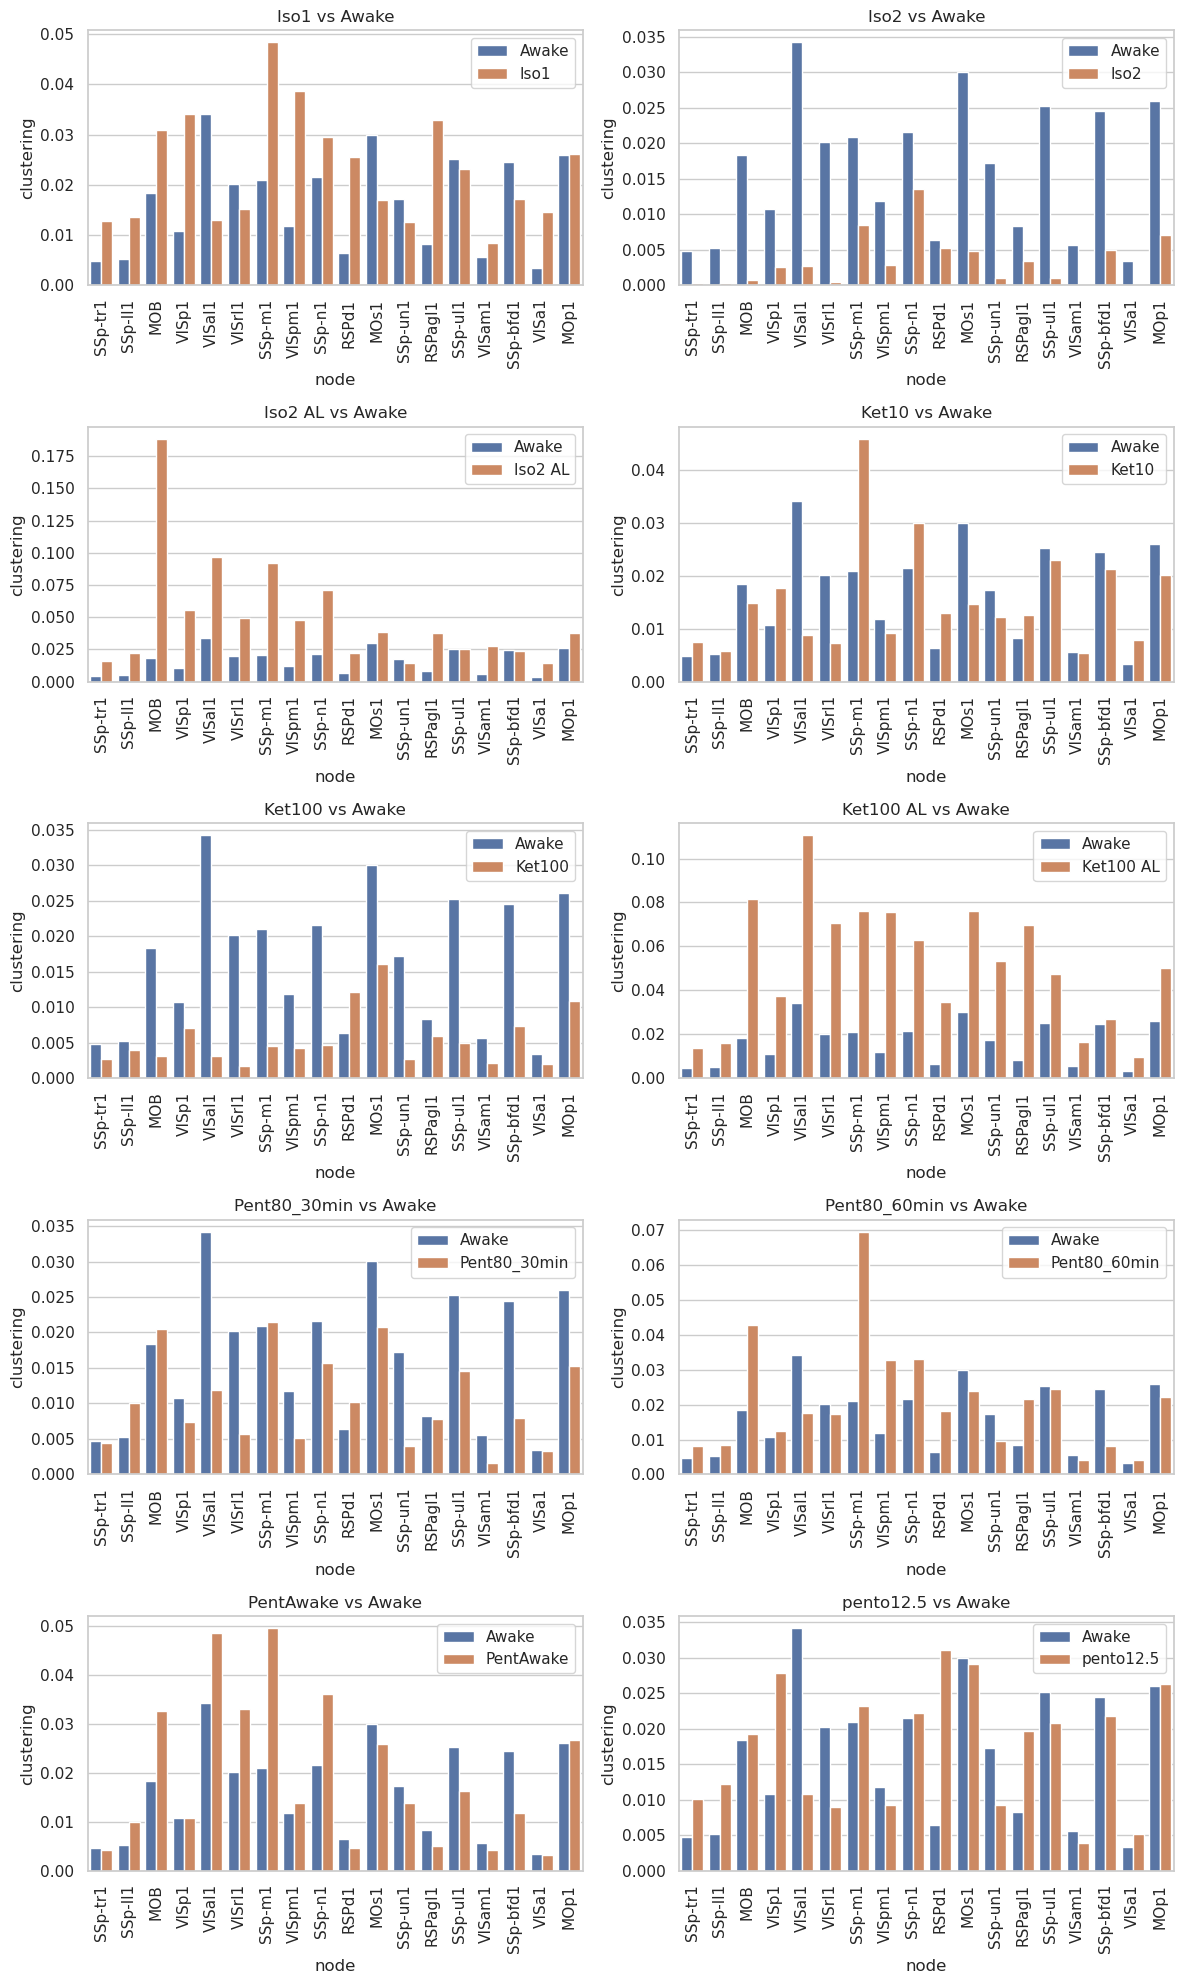

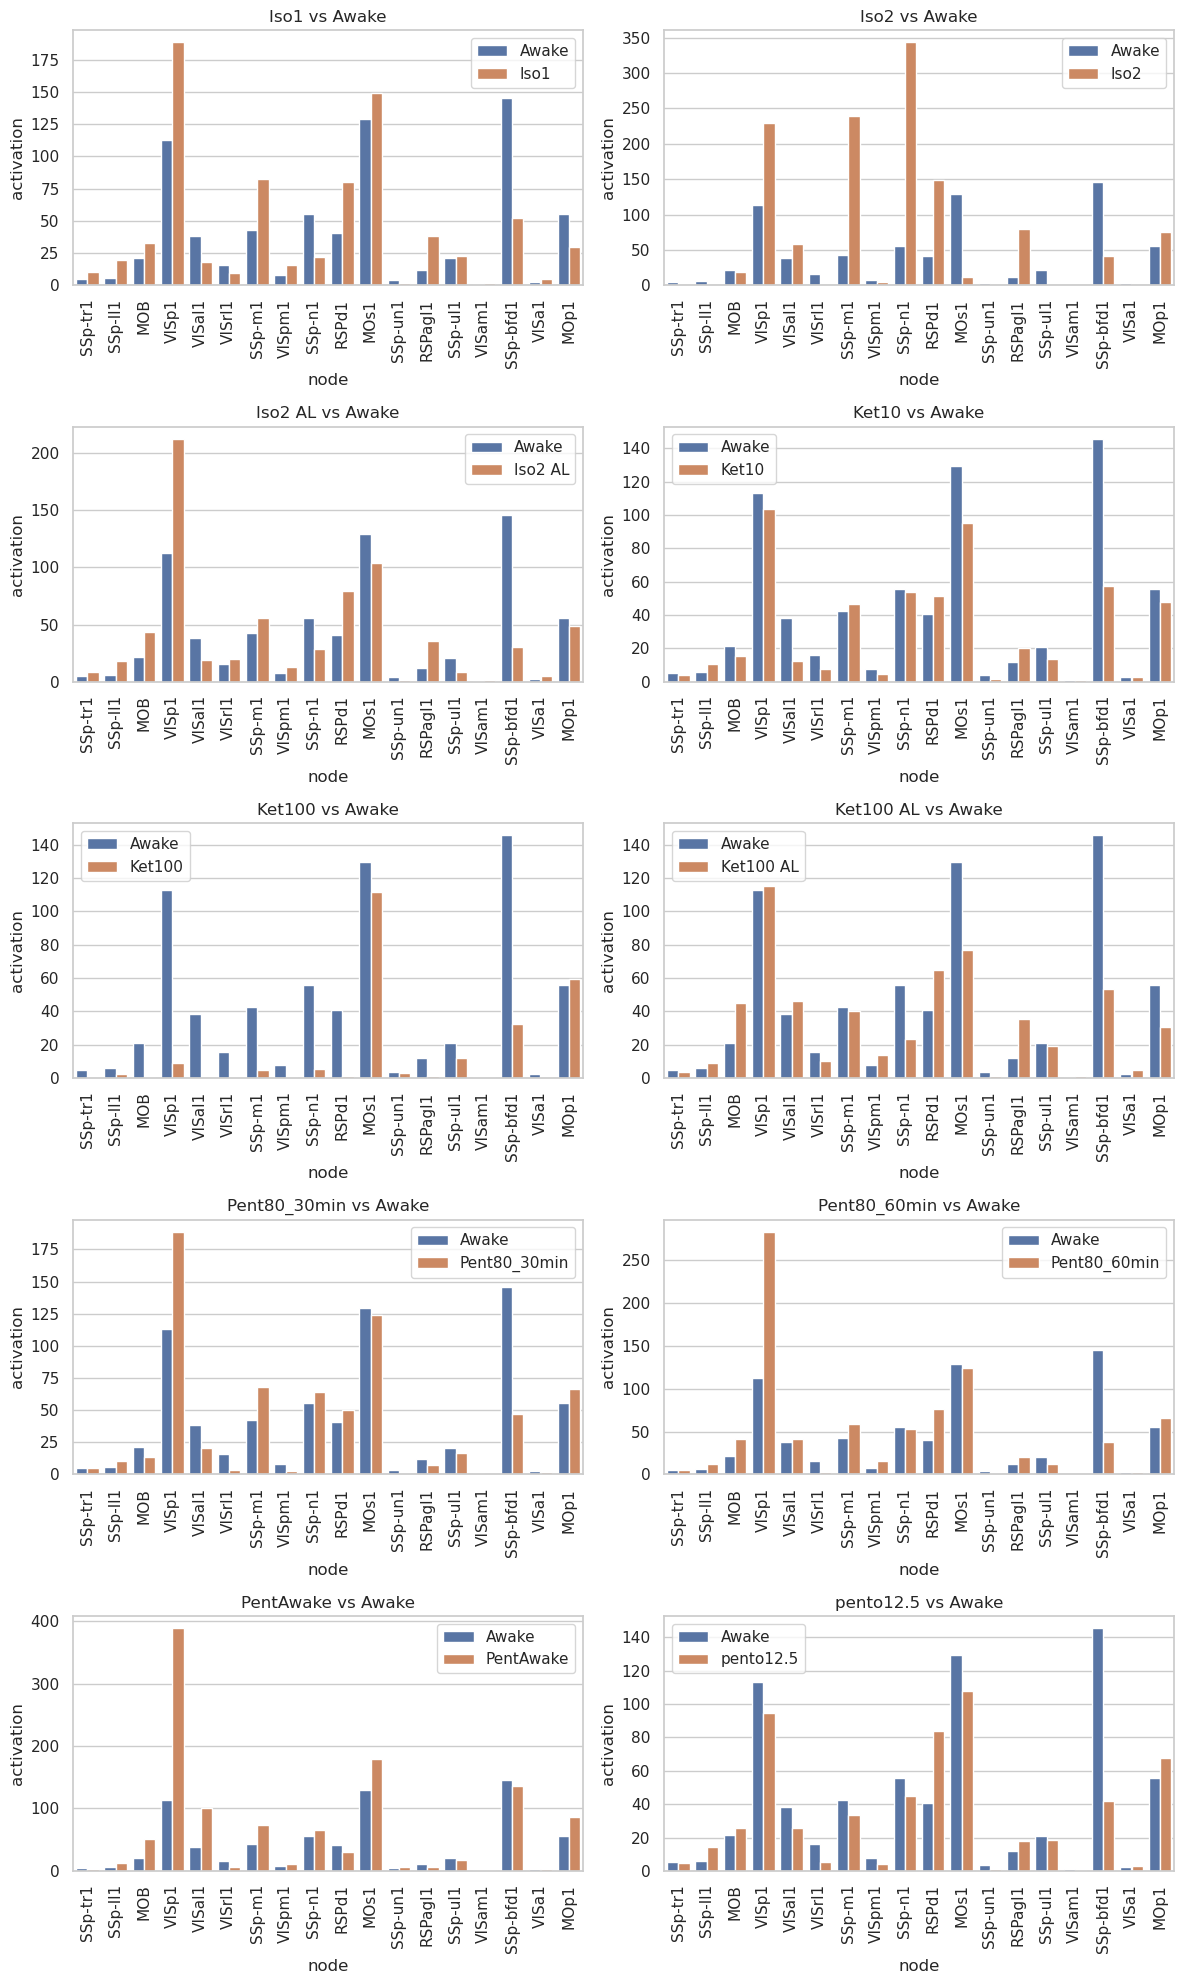

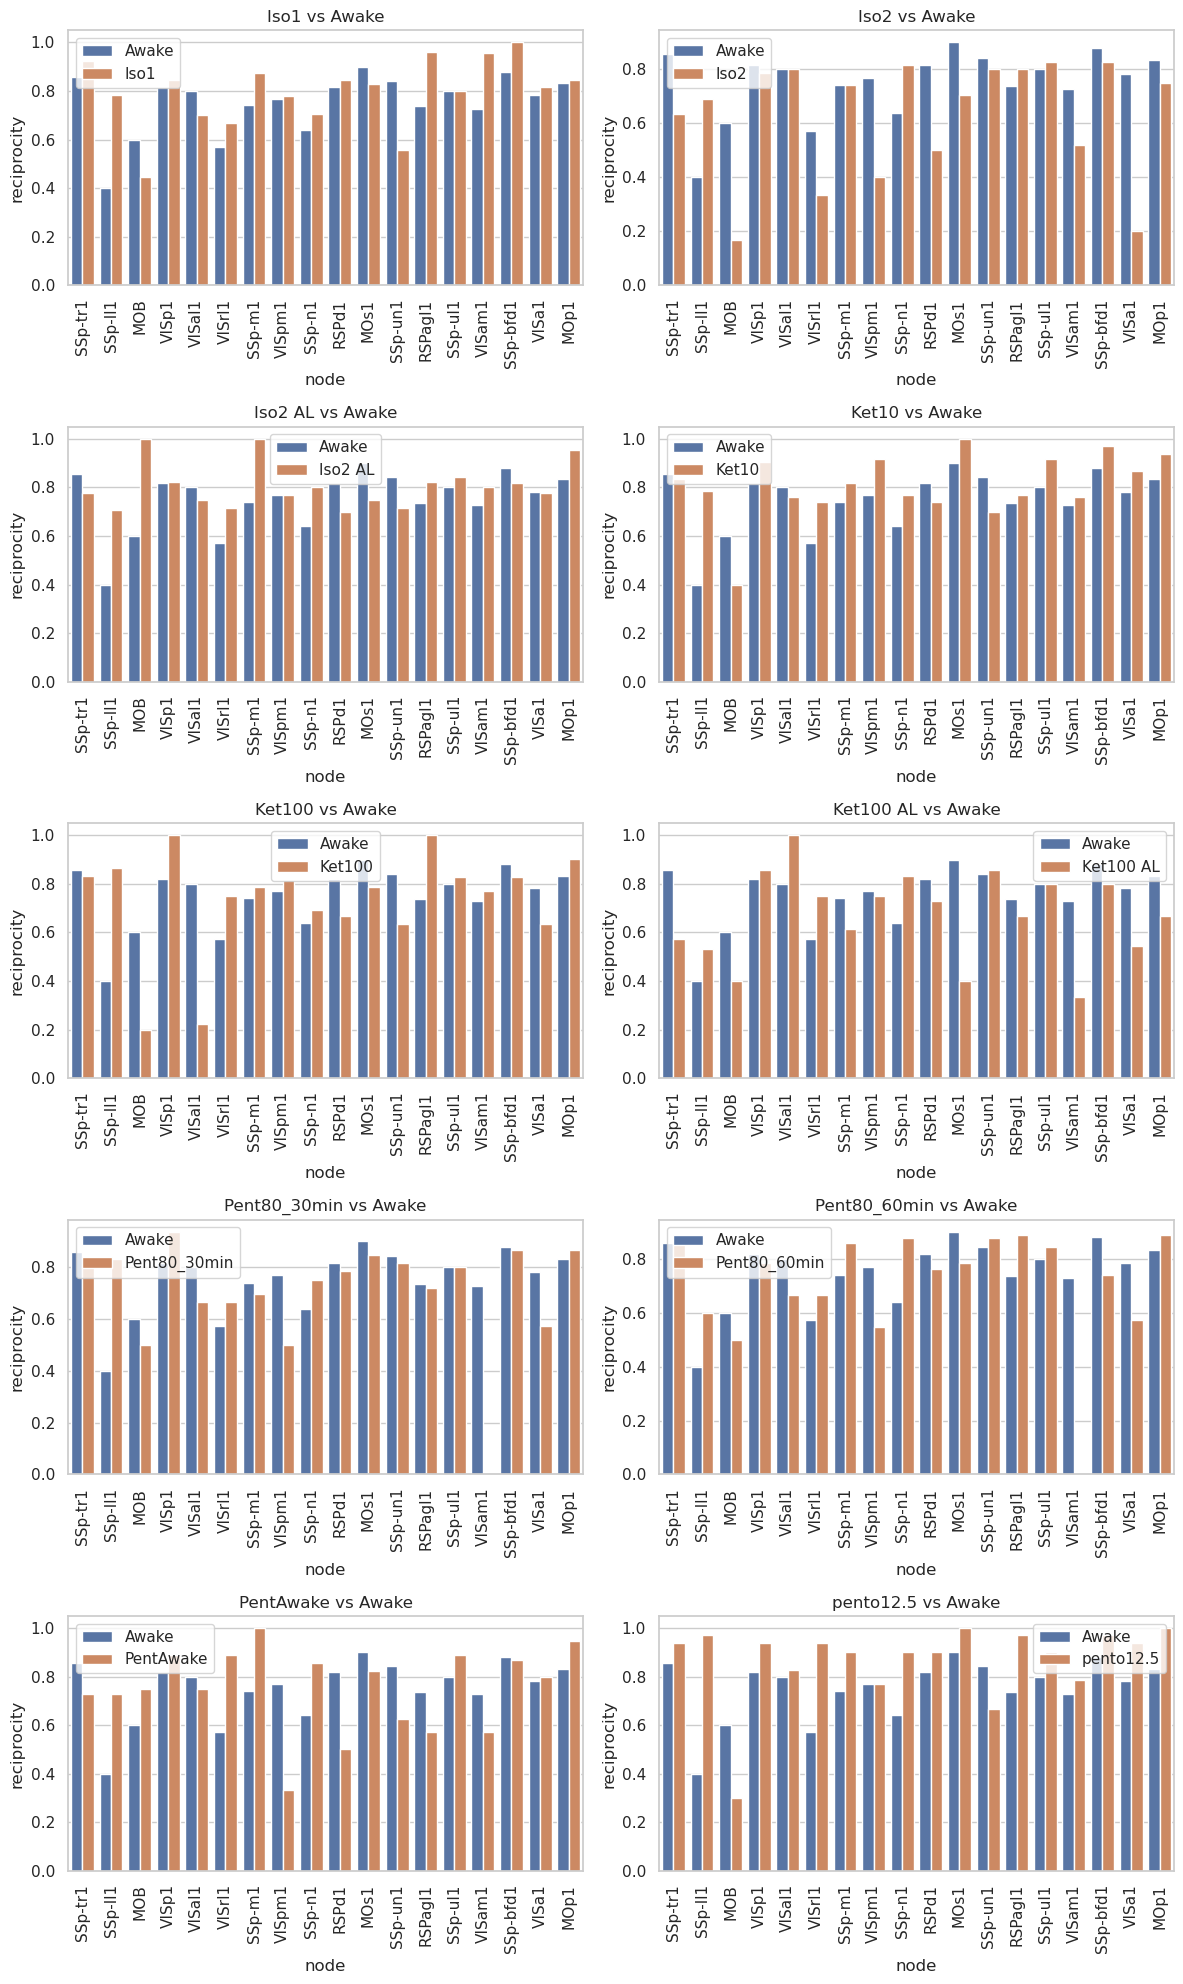

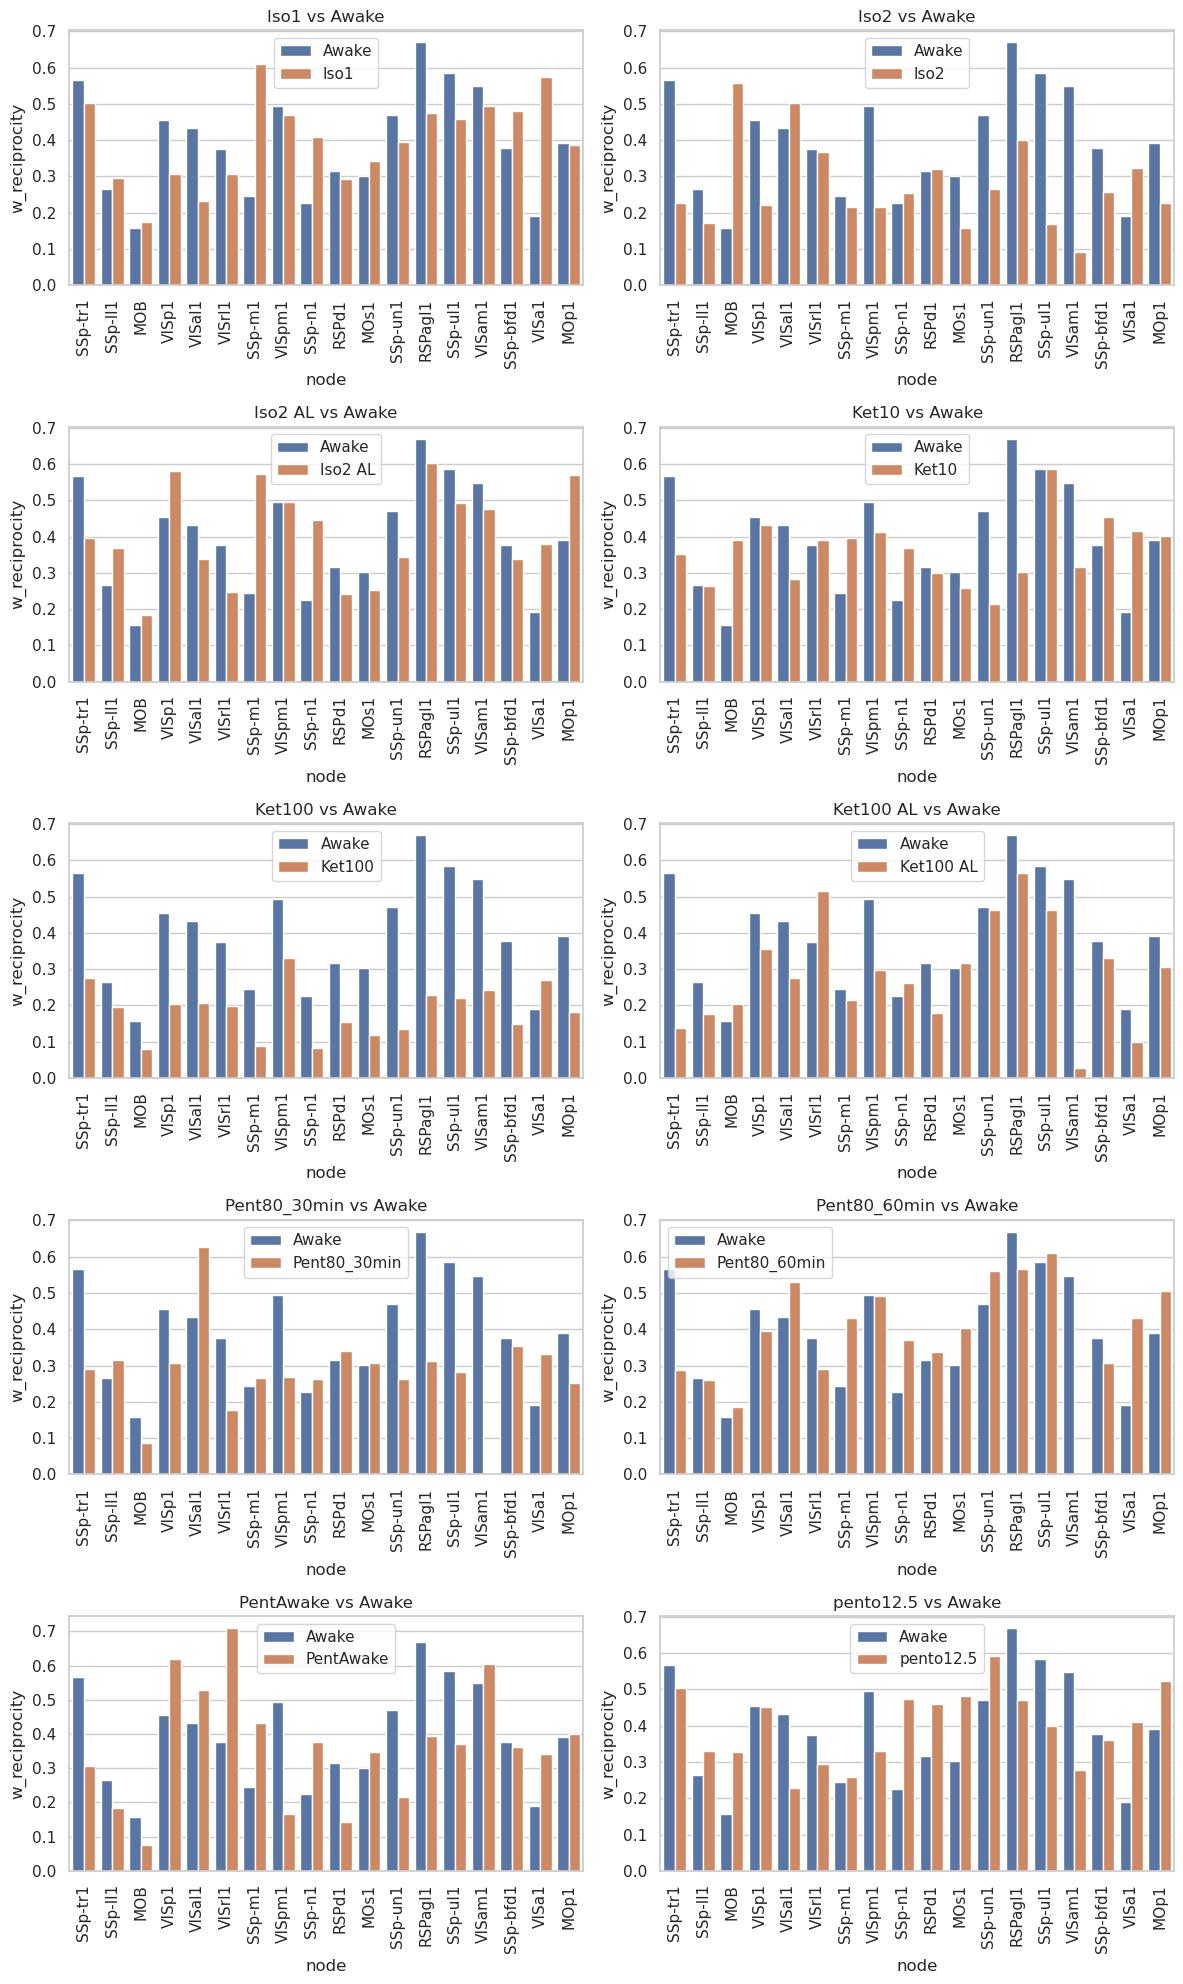

In [27]:
cols = list(node_df.columns)
[cols.remove(x) for x in ['node', 'condition']]


for metric in cols:
    
    # Ensure seaborn styling
    sns.set(style="whitegrid")
    # Get list of unique conditions (excluding baseline)
    baseline = reference
    all_conditions = node_df['condition'].unique()
    compare_conditions = [cond for cond in all_conditions if cond != baseline]
    
    # Prepare figure
    n = len(compare_conditions)
    ncols = 2
    nrows = int(np.ceil(n*1./ncols))
    
    #fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4 * nrows), sharex=False)
    
    if n == 1:
        axes = [axes]  # make iterable if only one subplot
    
    # Plot each condition vs. baseline
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows), sharex=False)
    axes = axes.flatten()  # Flatten to 1D for easy indexing
    
    for i, cond in enumerate(compare_conditions):
        ax = axes[i]
        # Subset the dataframe for baseline and current condition
        df_baseline = node_df[node_df['condition'] == baseline]
        df_current = node_df[node_df['condition'] == cond]
    
        # Merge the two on 'node' so they're aligned
        merged = pd.merge(df_baseline, df_current, on='node', suffixes=('_baseline', f'_{cond}'))
    
        # Melt for seaborn
        plot_df = pd.melt(
            merged,
            id_vars='node',
            value_vars=[metric + '_baseline', f'{metric}_{cond}'],
            var_name='source',
            value_name= metric
        )
    
        # Clean up labels for clarity
        plot_df['source'] = plot_df['source'].map({
            metric + '_baseline': baseline,
            f'{metric}_{cond}': cond
        })
    
        # Plot
        sns.barplot(data=plot_df, x='node', y= metric, hue='source', ax=ax)
        ax.set_title(f'{cond} vs {baseline}')
        ax.set_ylabel(metric)
        #ax.set_xlabel('Node')
        ax.tick_params(axis='x', rotation=90)
        ax.legend()#title='Condition')
    
    # If there are unused subplots, hide them
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])  # or axes[j].axis('off')
    
    
    plt.tight_layout()
    #plt.show()
    
    save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
    fig.savefig(save_dir + 'nodes_metric=' + metric + '_againstref=' + reference +  '.png')


In [40]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

node_df = pd.read_csv(avg_graphs_meta['nodedf']['path'] + '.csv')

graphs = dict()
for key in avg_graphs_meta['avg_graph'].keys():
    G = nx.read_gml(avg_graphs_meta[load_name][key]['path'] + '.' + avg_graphs_meta[load_name][key]['format'])
    graphs[key] = G

In [44]:
cols = list(node_df.columns)
[cols.remove(x) for x in ['node', 'condition', 'Unnamed: 0']]


key = list(graphs.keys())
df = pd.DataFrame({'keys' : key})
metric_list = list()

for key in graphs.keys():
    G = graphs[key]
    #print(key,nx.is_strongly_connected(G))
       
    # Get the edge weights for each edge in the graph
    weights = list(nx.get_edge_attributes(G, 'weight').values())
    X = weights 
    tag = 'weight'
    metric_list.append(tag)
    df = my.get_stats(X, tag, key, df)
    
    
    #get pre-calculated node stats
    for c in cols:
        X = [G.nodes[node][c] for node in list(G.nodes())]
        df = my.get_stats(X, c, key, df)
        metric_list.append(c)
    

    #get gini coefficient
    X = my.gini(weights)
    tag = 'gini'
    metric_list.append(tag)
    df = my.get_stats(X, tag, key, df)

    #get average shortest path
    if nx.is_strongly_connected(G):
        X = nx.average_shortest_path_length(G, weight = lambda x,y,z: 1/z['weight'])
        tag = 'ASPL'
        metric_list.append(tag)
        df = my.get_stats(X, tag, key, df)
    else:
        g_strong = G.copy()
        X = 0
        tag = 'ASPL'
        metric_list.append(tag)
        df = my.get_stats(X, tag, key, df)
        
metric_list = list(set(metric_list))        
df.head()




#save the node_df file
save_name = 'avg_graph_stats_df'
save_dir = str(result_dir / 'averaged_graphs')
avg_graphs_meta[save_name] = {'path': str(save_dir) + '/' + save_name,
                                    'save_dir': str(save_dir),
                                    'save_name': save_name,
                                    'format' : 'csv',
                                    'num_cols' : df.shape[1],
                                    'num_rows' : df.shape[0],
                                    'metric_list': metric_list
                                   }

df.to_csv(avg_graphs_meta[save_name]['path'] + '.csv')



In [52]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

df = pd.read_csv(avg_graphs_meta['avg_graph_stats_df']['path'] + '.csv')
metric_list = avg_graphs_meta['avg_graph_stats_df']['metric_list']

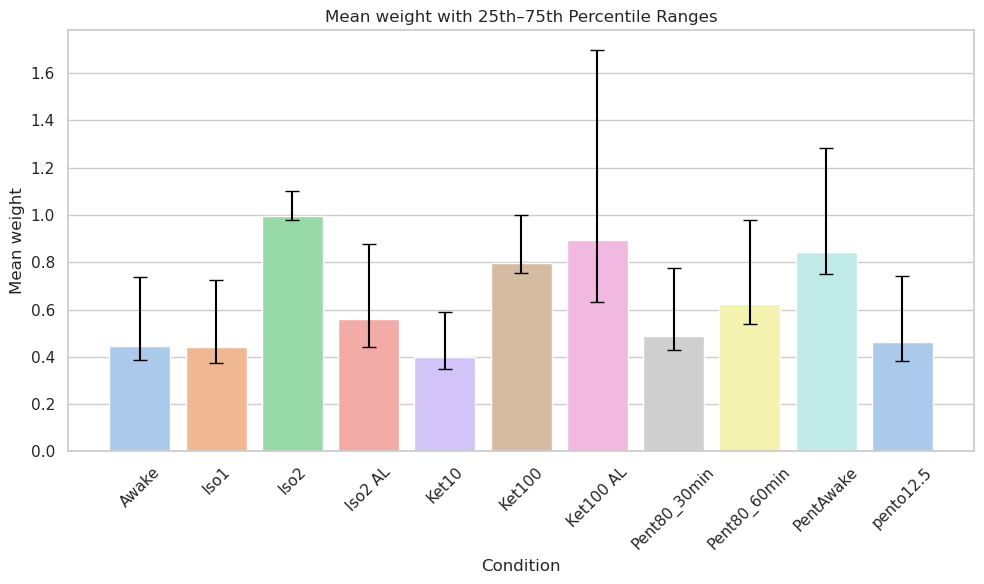

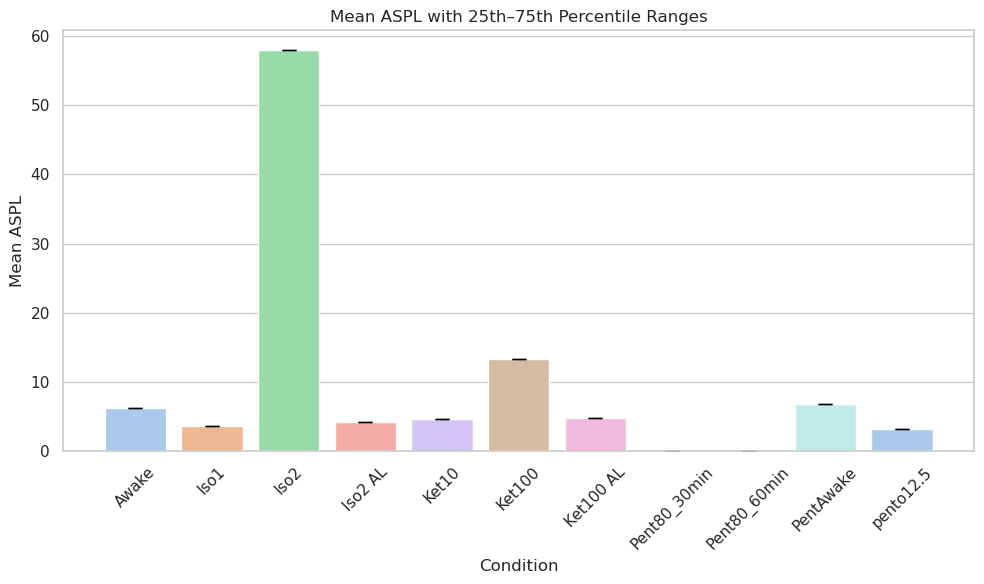

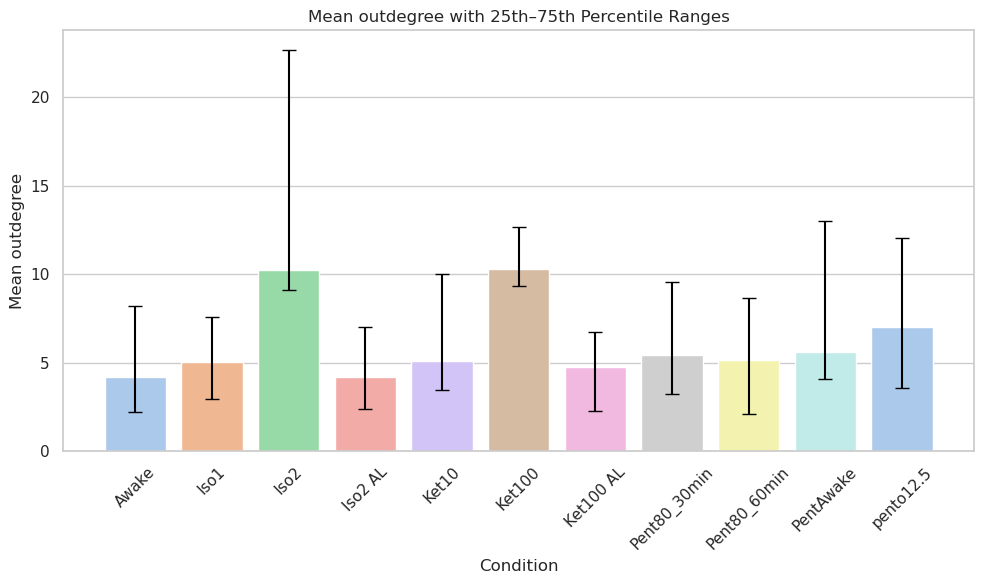

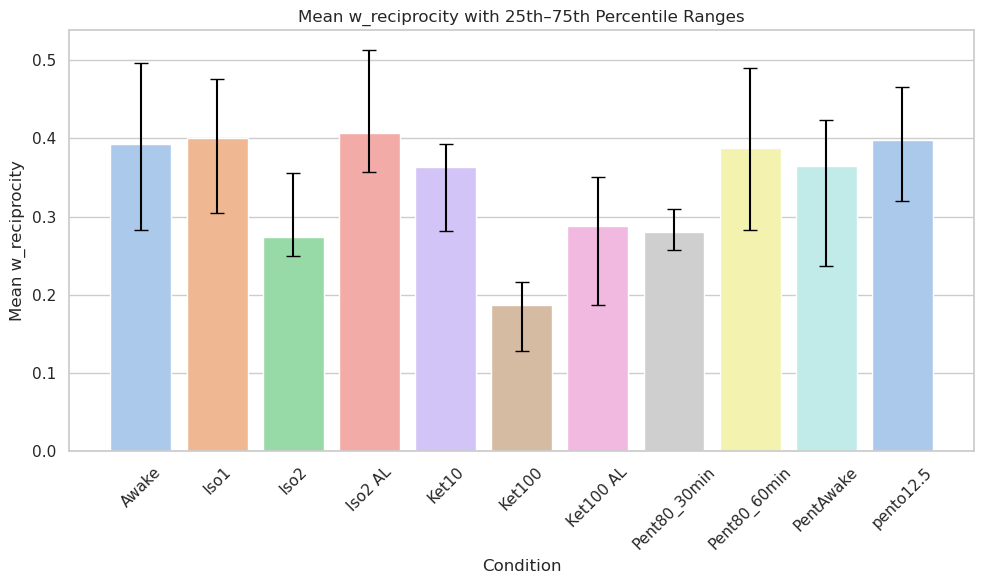

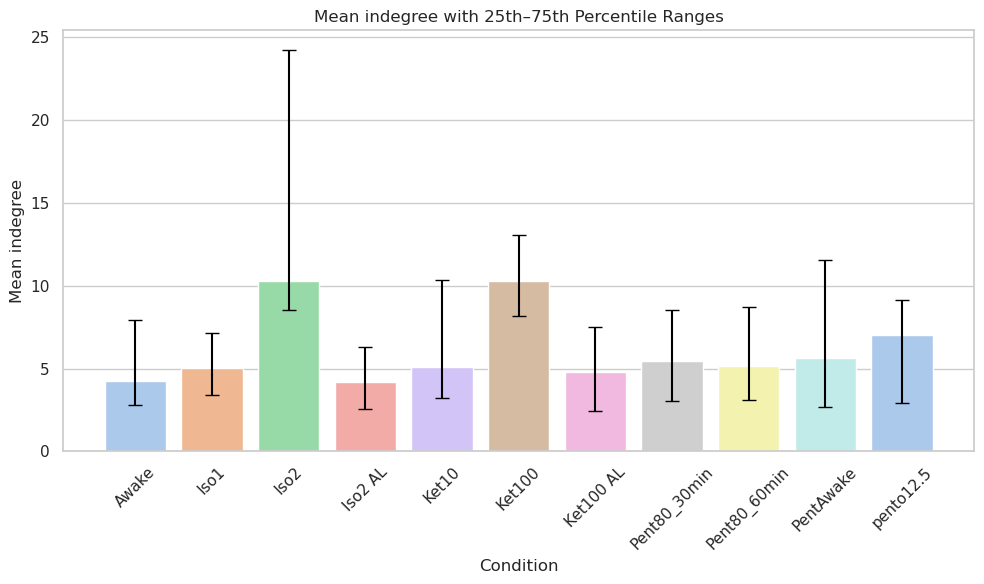

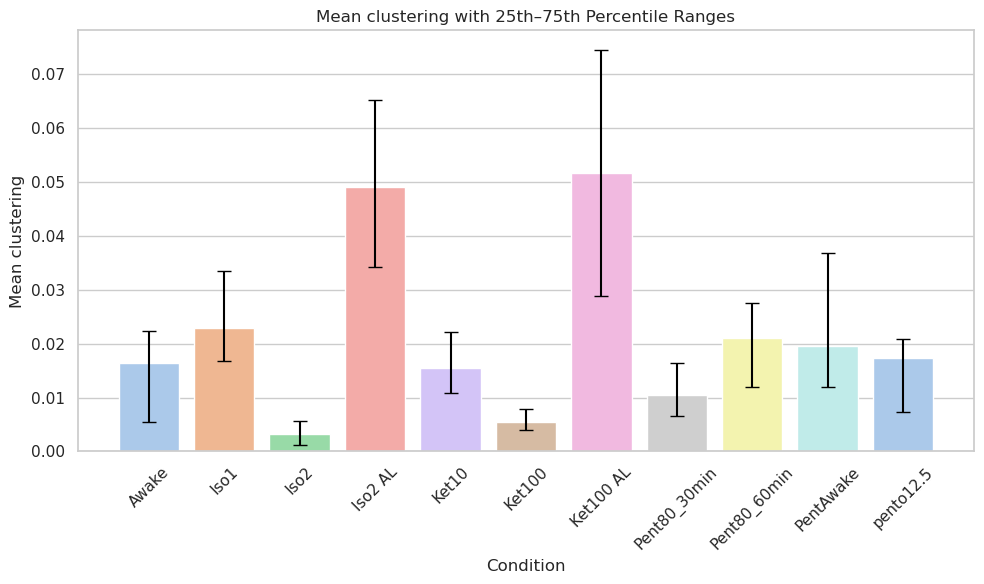

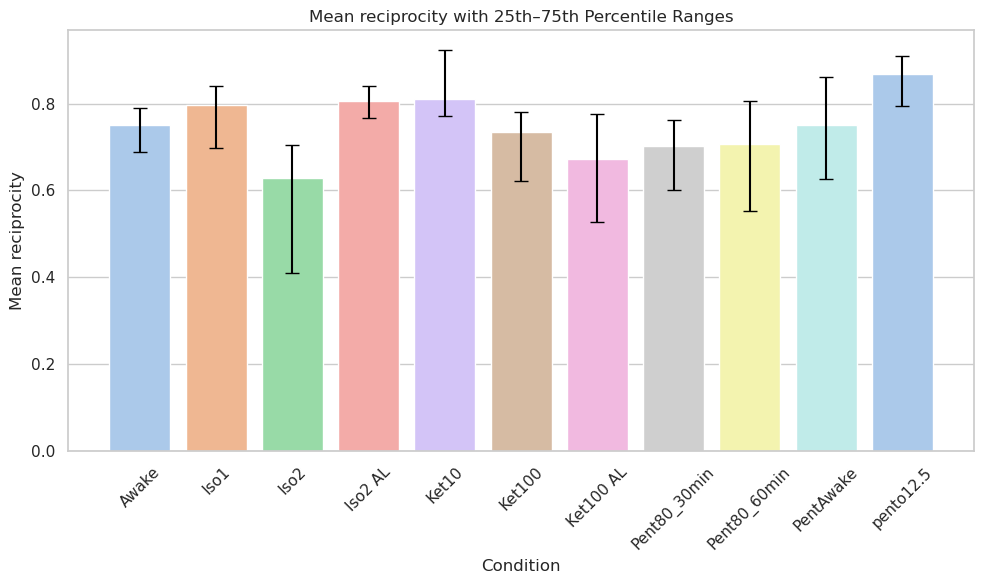

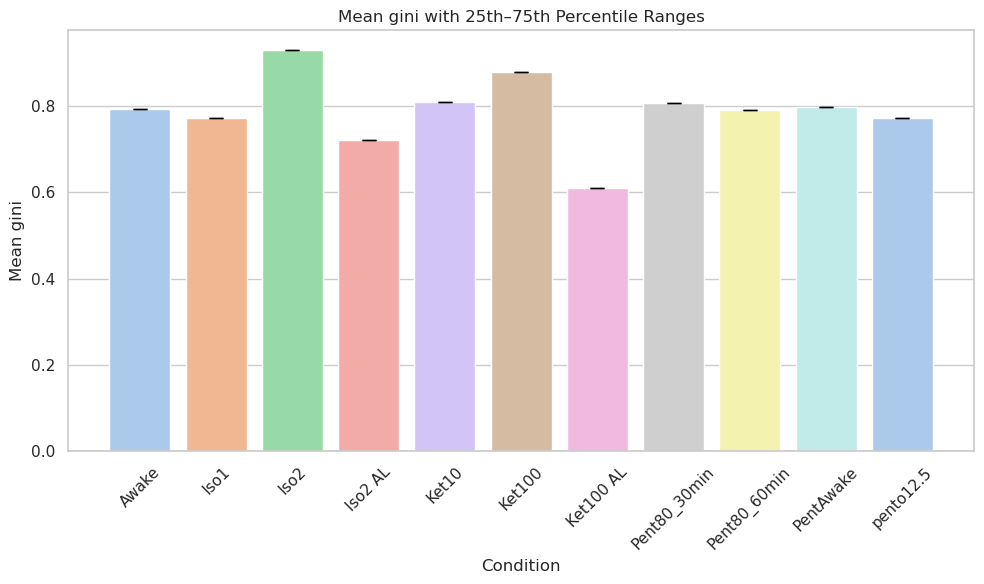

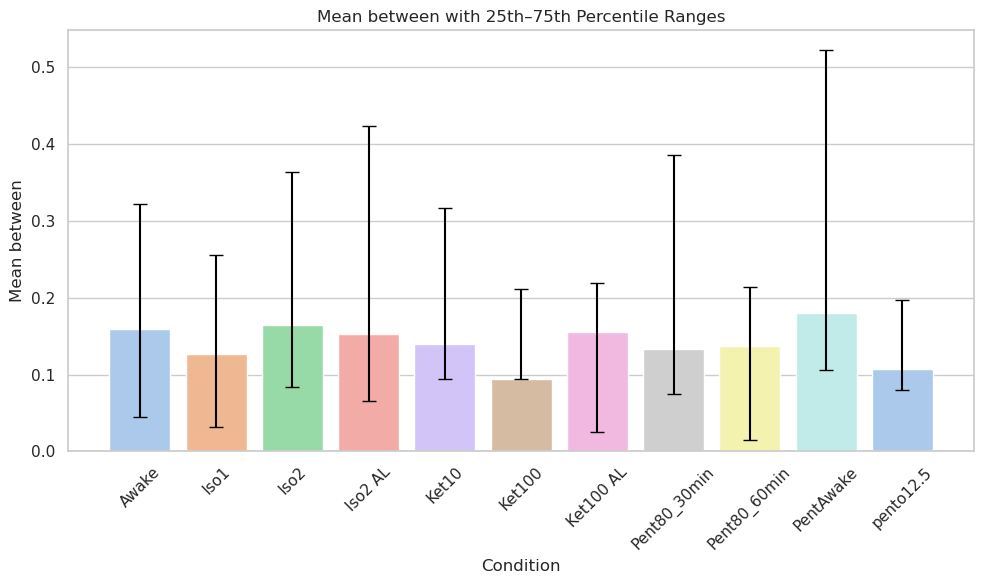

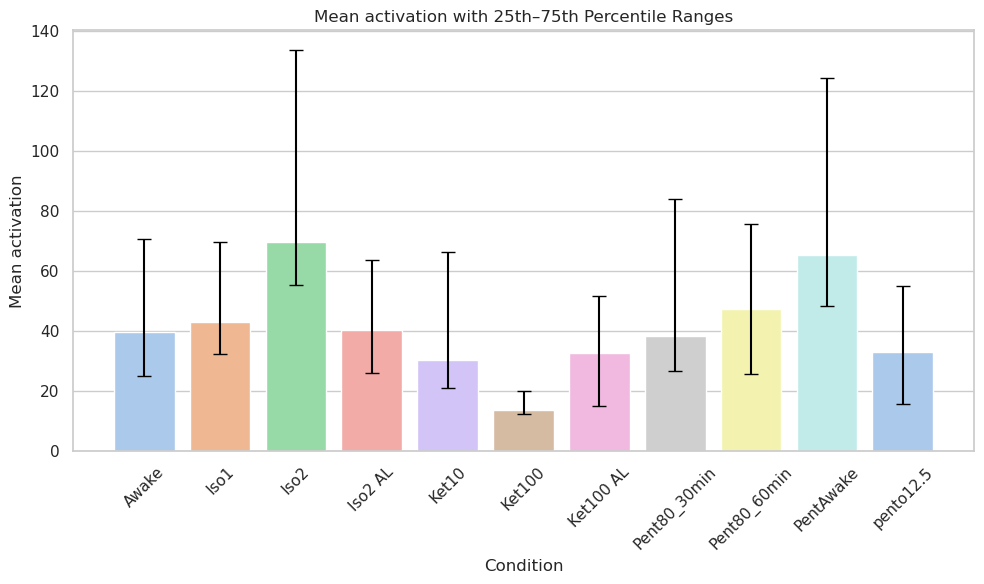

In [56]:

for metric in metric_list:
    # Create figure and axis
    plt.figure(figsize=(10, 6))
    
    # Make the barplot but disable CI/errorbars
    barplot = sns.barplot(data=df, x='keys', y= metric + '_mean',  errorbar=None, hue = 'keys', palette='pastel')
    
    # Add error bars manually
    # Get the positions of the bars
    x_coords = []
    for bars in barplot.containers:
        for bar in bars:
            x = bar.get_x() + bar.get_width() / 2
            x_coords.append(x)
    x_coords = np.sort(x_coords)
    
    
    # Extract error values
    yerr_lower = df[metric + '_25th'].values
    yerr_upper = df[metric + '_75th'].values
    yerr = [yerr_lower, yerr_upper]
    
    # Add error bars
    plt.errorbar(x_coords, df[metric + '_mean'], yerr=yerr, fmt='none', ecolor='black', capsize=5)
    
    # Final touches
    plt.xlabel('Condition')
    plt.ylabel('Mean ' + metric)
    plt.title('Mean ' + metric + ' with 25th–75th Percentile Ranges')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    fig = barplot.get_figure()
    save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
    fig.savefig(save_dir + 'avg_graph_metric_barplots=' + metric + '.png')

In [70]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

graphs = dict()
for key in avg_graphs_meta['avg_graph'].keys():
    G = nx.read_gml(avg_graphs_meta[load_name][key]['path'] + '.' + avg_graphs_meta[load_name][key]['format'])
    graphs[key] = G

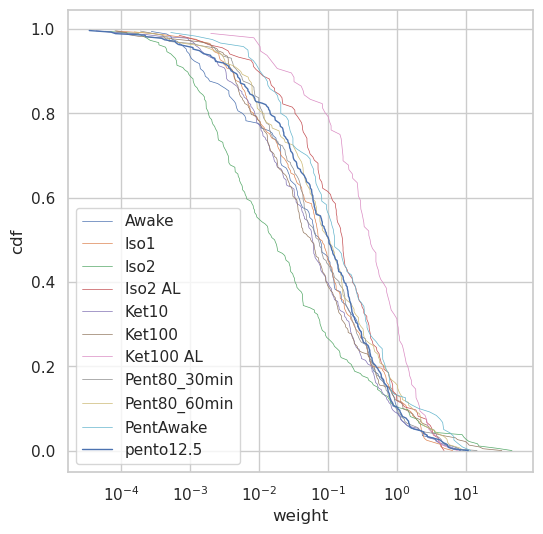

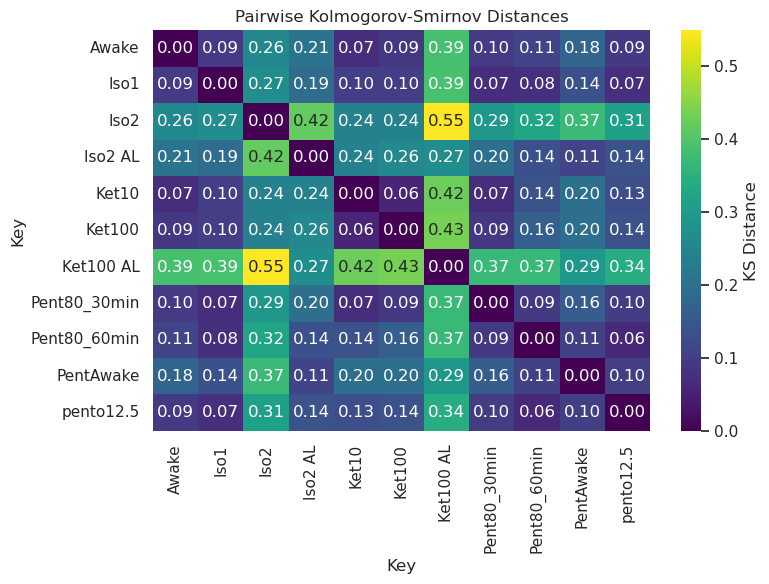

In [110]:
import seaborn as sns
from scipy.stats import ks_2samp


def plot_ks_distance_matrix(weights):
    keys = list(weights.keys())
    n = len(keys)
    
    # Initialize matrix to store KS distances (D-statistic)
    ks_distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i <= j:  # Compute upper triangle and diagonal
                d_stat, _ = ks_2samp(weights[keys[i]], weights[keys[j]])
                ks_distances[i, j] = d_stat
                ks_distances[j, i] = d_stat  # Symmetric matrix
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    snsplot = sns.heatmap(ks_distances, xticklabels=keys, yticklabels=keys,
                annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'KS Distance'})
    plt.title("Pairwise Kolmogorov-Smirnov Distances")
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.tight_layout()
    fig = snsplot.get_figure()
    return fig
    


# plot weight distribution for each graph
plt.figure(figsize=(6,6))
colorcount = 0
lw = .5
dat = dict()
for i,key in enumerate(graphs.keys()):
    # Load the graph from the dictionary using its key
    G = graphs[key]
    weights = nx.get_edge_attributes(G, 'weight')

    dat[key] = list(weights.values())
    res = stats.ecdf(dat[key])

    #if the colours start to repeat then up the linewidth
    if colorcount > 9:
        lw += .5
        colorcount = 0
        
    fig = plt.plot(res.cdf.quantiles, 1-res.cdf.probabilities, label = key, lw = lw)
    colorcount += 1


plt.legend()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('weight');
plt.ylabel('cdf');


fig = plt.gcf()
save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
fig.savefig(save_dir + 'weights_cdf' + '.png')


fig = plot_ks_distance_matrix(dat)
save_dir = my.check_if_dir_exists(str(result_dir / 'averaged_graphs') +'/figures/')
fig.savefig(save_dir + 'pairwise_KS_distance_matrix' + '.png')


In [ ]:
for key in np.unique(df['keys']):
    my.draw_weighted_graph(graphs[key], title = key, figsize = (1,1))

In [122]:
with open(str(result_dir / 'averaged_graphs') + '/avg_graphs_meta.pkl', 'rb') as f:
    avg_graphs_meta = pickle.load(f)  

node_df = pd.read_csv(avg_graphs_meta['nodedf']['path'] + '.csv')
cols = list(node_df.columns)
[cols.remove(x) for x in ['node', 'condition', 'Unnamed: 0']]


graphs = dict()
for key in avg_graphs_meta['avg_graph'].keys():
    G = nx.read_gml(avg_graphs_meta['avg_graph'][key]['path'] + '.' + avg_graphs_meta['avg_graph'][key]['format'])
    graphs[key] = G

NameError: name 'stop' is not defined

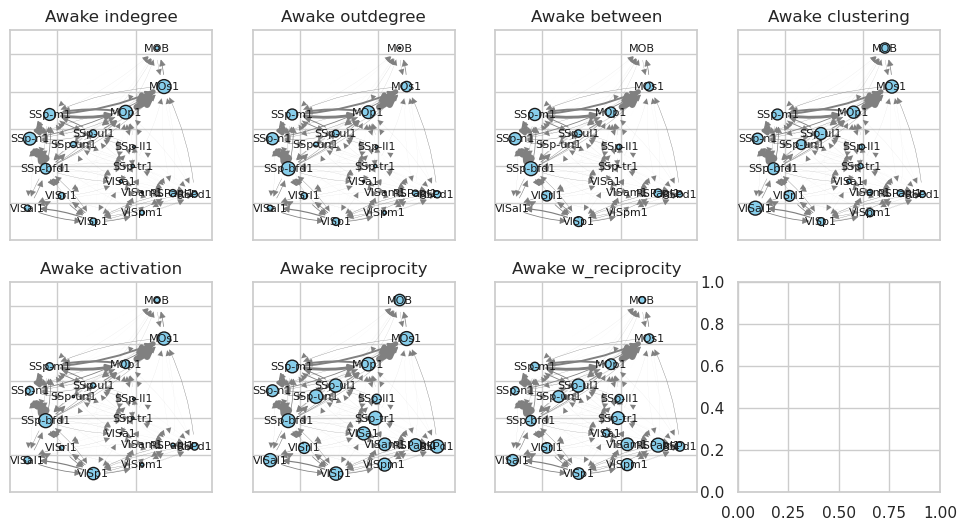

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [126]:
n = len(graphs.keys())
ncols = len(cols)
nrows = n#int(np.ceil(n / ncols))

#fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), sharex=False)
#axes = axes.flatten()  # Flatten to 1D for easy indexing

plotting_fac = 100;

count = 0
for i,key in enumerate(graphs.keys()):
    #if i >0:
        #continue
    #plt.sca(axes[i])
    G = graphs[key]
    # #get in degree stats

    nrows = int(np.ceil(3./4*np.sqrt(len(cols))))
    ncols = int(np.ceil(4./3*np.sqrt(len(cols))))
                
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), sharex=False);
    axes = axes.flatten() ; # Flatten to 1D for easy indexing
    count = 0
    
    for c in cols:
        node_size = np.array([G.nodes[node][c] for node in list(G.nodes())])
        node_size = plotting_fac*node_size/max(node_size)
        my.draw_weighted_graph(G, node_size = node_size, title = key + ' ' + c, figsize = (1,1), ax = axes[count]);
        count += 1


    plt.tight_layout();
    #fig = plt.gcf()

    
    save_dir = my.check_if_dir_exists(result_dir / 'averaged_graphs' / key )
    save_name = 'avg_graphs_nodes_weighted_metric'        
    #save the figure
    fig.savefig(str(save_dir) + '/' + save_name + '.png')
    stop



In [486]:
cols = list(node_df.columns)
[cols.remove(x) for x in ['node', 'condition']]
surr_df = pd.DataFrame(columns = cols)

key = 'Ket100'
n_surrogates = 20
G_surr = my.generate_multiple_surrogates(graphs[key], n_surrogates = n_surrogates, seed=None)
for k in range(n_surrogates):
    stats_df, G_surr[k] = my.calculate_node_proprties(G_surr[k], key)
    mean_df = stats_df.drop(['node', 'condition'], axis = 1).mean()
    row = {x:y for (x,y) in zip(list(mean_df.keys()),mean_df.values)}
    row = pd.DataFrame(row, index = [k])
    surr_df = pd.concat([surr_df, row])
surr_df.head(20)

/tmp/ipykernel_3577334/2901361749.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surr_df = pd.concat([surr_df, row])


indegree  outdegree   between  clustering  activation  reciprocity  \
0   10.293387  10.293387  0.151552    0.003966   13.680556     0.734322   
1   10.293387  10.293387  0.182802    0.003599   13.680556     0.734322   
2   10.293387  10.293387  0.145425    0.003781   13.680556     0.734322   
3   10.293387  10.293387  0.133374    0.003875   13.680556     0.734322   
4   10.293387  10.293387  0.144199    0.003767   13.680556     0.734322   
5   10.293387  10.293387  0.152165    0.004114   13.680556     0.734322   
6   10.293387  10.293387  0.109886    0.003883   13.680556     0.734322   
7   10.293387  10.293387  0.152574    0.003685   13.680556     0.734322   
8   10.293387  10.293387  0.121324    0.003688   13.680556     0.734322   
9   10.293387  10.293387  0.125613    0.003870   13.680556     0.734322   
10  10.293387  10.293387  0.136234    0.003860   13.680556     0.734322   
11  10.293387  10.293387  0.128881    0.003849   13.680556     0.734322   
12  10.293387  10.293387  0.134191    0.003588   13.680556     0.734322   
13  10.293387  10.293387  0.132966    0.003883   13.680556     0.734322   
14  10.293387  10.293387  0.138072    0.003824   13.680556     0.734322   
15  10.293387  10.293387  0.114992    0.003730   13.680556     0.734322   
16  10.293387  10.293387  0.129902    0.003789   13.680556     0.734322   
17  10.293387  10.293387  0.126430    0.003699   13.680556     0.734322   
18  10.293387  10.293387  0.141544    0.003669   13.680556     0.734322   
19  10.293387  10.293387  0.130515    0.003580   13.680556     0.734322   

    w_reciprocity  
0        0.201995  
1        0.206708  
2        0.200806  
3        0.188667  
4        0.183166  
5        0.189313  
6        0.202710  
7        0.150431  
8        0.186748  
9        0.176512  
10       0.178421  
11       0.205924  
12       0.259223  
13       0.171429  
14       0.176883  
15       0.207853  
16       0.176199  
17       0.210047  
18       0.229823  
19       0.239132

In [488]:

mean_df = node_df[node_df['condition'] == key]
mean_df = mean_df.drop(['node', 'condition'], axis = 1).mean()
mean_df = {x:y for (x,y) in zip(list(mean_df.keys()),mean_df.values)}
mean_df = pd.DataFrame(mean_df, index = [0])
mean_df.head()


indegree  outdegree   between  clustering  activation  reciprocity  \
0  10.293387  10.293387  0.094567    0.005495   13.680556     0.734322   

   w_reciprocity  
0       0.186821